# Broadband market assessment

This project is looking at several government data sources to assess the market saturation of broadband providers and predicting markets ripe for additional providers.

The website to display the findings will be located at http://broadband-market.herokuapp.com/.

The intial data sources include:

   * The broadbandmap- http://www.broadbandmap.gov/, an already extensive resource in itself.
    
   * The census 2015 planning database using the most recent census estimates, (2013 for sub-county level data)-  [https://www.census.gov/data/developers/data-sets/planning-database.html](https://www.census.gov/data/developers/data-sets/planning-database.html)
    
   * The 2012 Economic Census - https://www.census.gov/data/developers/data-sets/economic-census.html
   
API calls will be used to access these data sources.

## Broadband map 
The broadband map is updated every 6 months and has metrics such as speed tests, providers, technologies(copper, fiber,etc.), and grant funding supplied through BTOP or BIP to providers in an area.

For more information on funding intitiatives: 

Broadband Initiatives Program (BIP)- http://www.usda.gov/oig/webdocs/09703-0002-32.pdf

>   American Recovery and Reinvestment Act of 
2009 (Recovery Act), Congress authorized 
the Rural Utilities 
Service’s (
RUS
)
Broadband Initiatives Program (BIP) to help bring 
broadband to rural areas of the United States where residents might 
otherwise not have access to this important technology

Broadband Technology Opportunities Program (BTOP)- http://www.ntia.doc.gov/category/broadband-technology-opportunities-program

>The Broadband Technology Opportunities Program (BTOP) is an approximately $4 billion grant program administered by NTIA to help bridge the technological divide; create jobs; and improve education, health care, and public safety in communities across the country. Funded by the American Recovery and Reinvestment Act of 2009

## Census 2015 planning database

This database contains population characteristics inluding age breakdowns as well as house value and income medians. Information is available at the nation, state, county, census tract, and census block group levels. 


##Economic Census 2012
The economic census contains indutrsy related data including number of establishments, number of employees, value of business done, and payroll by NAICS industry divisions(http://www.census.gov/eos/www/naics/)

###Additional resources
If time permits additional consideration will be given to historical data for the census and economic census data.

## Notebook

In [2]:
%matplotlib inline
import matplotlib
import seaborn as sns
import pylab as pl
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
import requests
from requests_futures.sessions import FuturesSession
from bs4 import BeautifulSoup
import re
import urllib 
import os
import sys
import pandas as pd
sys.path.append('/usr/local/lib/python2.7/dist-packages') 
import vincent
import pickle
from StringIO import StringIO as strIO

## Preliminary look at broadband download data
We begin with looking at the speed test data from Broadbandmap.gov at the county level. Eventual would like to look at census tract or census block levels but starting at county level.

In [3]:
##Get County FIPS IDs
county_fips_url='http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt'
county_fips=pd.read_table(county_fips_url, sep=',', header=None, names=['state_abbrev','state_fp', 'county_fp', 'countyName', 'fp_class_code'])
county_fips['st_county_id']=county_fips['state_fp']*1000+county_fips['county_fp']
county_fips['st_county_id_str']=county_fips['st_county_id'].map("{:05}".format)
county_fips.head()

state_abbrev  state_fp  county_fp      countyName fp_class_code  \
0           AL         1          1  Autauga County            H1   
1           AL         1          3  Baldwin County            H1   
2           AL         1          5  Barbour County            H1   
3           AL         1          7     Bibb County            H1   
4           AL         1          9   Blount County            H1   

   st_county_id st_county_id_str  
0          1001            01001  
1          1003            01003  
2          1005            01005  
3          1007            01007  
4          1009            01009

In [4]:
## Create county list string for API call
def create_string_list(county_list):
    return ','.join(county_list['st_county_id_str'])

print county_fips[['state_fp','st_county_id_str']].head()
counties_stringsDF=county_fips[['state_fp','st_county_id_str']].groupby('state_fp').apply(create_string_list)
print counties_stringsDF.head()
print counties_stringsDF[1]

   state_fp st_county_id_str
0         1            01001
1         1            01003
2         1            01005
3         1            01007
4         1            01009
state_fp
1    01001,01003,01005,01007,01009,01011,01013,0101...
2    02013,02016,02020,02050,02060,02068,02070,0209...
4    04001,04003,04005,04007,04009,04011,04012,0401...
5    05001,05003,05005,05007,05009,05011,05013,0501...
6    06001,06003,06005,06007,06009,06011,06013,0601...
dtype: object
01001,01003,01005,01007,01009,01011,01013,01015,01017,01019,01021,01023,01025,01027,01029,01031,01033,01035,01037,01039,01041,01043,01045,01047,01049,01051,01053,01055,01057,01059,01061,01063,01065,01067,01069,01071,01073,01075,01077,01079,01081,01083,01085,01087,01089,01091,01093,01095,01097,01099,01101,01103,01105,01107,01109,01111,01113,01115,01117,01119,01121,01123,01125,01127,01129,01131,01133


In [5]:
#speedtest example call: www.broadbandmap.gov/broadbandmap/speedtest/county/ids/01,02?format=json
base_url='http://www.broadbandmap.gov/broadbandmap/speedtest/county/ids/'
session = FuturesSession(max_workers=15)

# multiple resolutions available:state, county, censusplace, msa, usf, statesenate, statehouse, congdistrict, tribalnation.
print counties_stringsDF.head(1)
urls=(base_url+counties_stringsDF+'?format=json').tolist()

#Send multiple requests at once
futures = [session.get(url) for url in urls]
state_responses = [future.result() for future in futures]

state_fp
1    01001,01003,01005,01007,01009,01011,01013,0101...
dtype: object


In [6]:
print state_responses[1].url
print state_responses[1].text[0:500]

http://www.broadbandmap.gov/broadbandmap/speedtest/county/ids/02013,02016,02020,02050,02060,02068,02070,02090,02100,02105,02110,02122,02130,02150,02164,02170,02180,02185,02188,02195,02198,02220,02230,02240,02261,02270,02275,02282,02290?format=json
{"status":"OK","responseTime":1031,"message":["Maximum of only 10 parameters are allowed"],"Results":[{"geographyId":"02013","geographyName":"Aleutians East","accessingFrom":"Home","numberOfTests":2,"medianDownload":40.47103,"lowerQuartileDownload":21.00260,"upperQuartileDownload":59.93945,"medianUpload":16.19449,"lowerQuartileUpload":0.87598,"upperQuartileUpload":31.51300},{"geographyId":"02013","geographyName":"Aleutians East","accessingFrom":"Mobile","numberOfTests":19,"medianDownload":0.3867


In [7]:
##Check that with state with max number of counties no lost info
max_idx=county_fips[['state_fp','st_county_id_str']].groupby('state_fp').count().idxmax()
print max_idx #48
urls=(base_url+counties_stringsDF+'?format=json').tolist()
print urls[48]
example_response = requests.get(urls[48])
maxTestDF=pd.DataFrame(example_response.json()['Results'])
print maxTestDF.tail(1)
print 'received:',maxTestDF.tail(1).iloc[0,1],'last in list:', urls[48][-17:-12]

st_county_id_str    48
dtype: int64
http://www.broadbandmap.gov/broadbandmap/speedtest/county/ids/54001,54003,54005,54007,54009,54011,54013,54015,54017,54019,54021,54023,54025,54027,54029,54031,54033,54035,54037,54039,54041,54043,54045,54047,54049,54051,54053,54055,54057,54059,54061,54063,54065,54067,54069,54071,54073,54075,54077,54079,54081,54083,54085,54087,54089,54091,54093,54095,54097,54099,54101,54103,54105,54107,54109?format=json
    accessingFrom geographyId geographyName  lowerQuartileDownload  \
179        Mobile       54109       Wyoming                3.15527   

     lowerQuartileUpload  medianDownload  medianUpload  numberOfTests  \
179              0.45898          7.3667       0.46289             70   

     upperQuartileDownload  upperQuartileUpload  
179                7.58984              0.46484  
received: 54109 last in list: 54109


In [8]:
example_response.text[:1000]

u'{"status":"OK","responseTime":266,"message":["Maximum of only 10 parameters are allowed"],"Results":[{"geographyId":"54001","geographyName":"Barbour","accessingFrom":"Business","numberOfTests":3,"medianDownload":0.68760,"lowerQuartileDownload":0.60491,"upperQuartileDownload":0.72363,"medianUpload":1.01074,"lowerQuartileUpload":0.35800,"upperQuartileUpload":1.20996},{"geographyId":"54001","geographyName":"Barbour","accessingFrom":"CC_library_school","numberOfTests":1,"medianDownload":0.93475,"lowerQuartileDownload":0.93475,"upperQuartileDownload":0.93475,"medianUpload":1.15000,"lowerQuartileUpload":1.15000,"upperQuartileUpload":1.15000},{"geographyId":"54001","geographyName":"Barbour","accessingFrom":"Home","numberOfTests":9,"medianDownload":0.89258,"lowerQuartileDownload":0.54199,"upperQuartileDownload":1.58301,"medianUpload":0.40918,"lowerQuartileUpload":0.36523,"upperQuartileUpload":0.54883},{"geographyId":"54001","geographyName":"Barbour","accessingFrom":"Mobile","numberOfTests":6

In [9]:
example_response.json().keys()

[u'status', u'message', u'Results', u'responseTime']

In [10]:
example_response.json()['message']

[u'Maximum of only 10 parameters are allowed']

In [11]:
example_response.json()['Results'][0:3]

[{u'accessingFrom': u'Business',
  u'geographyId': u'54001',
  u'geographyName': u'Barbour',
  u'lowerQuartileDownload': 0.60491,
  u'lowerQuartileUpload': 0.358,
  u'medianDownload': 0.6876,
  u'medianUpload': 1.01074,
  u'numberOfTests': 3,
  u'upperQuartileDownload': 0.72363,
  u'upperQuartileUpload': 1.20996},
 {u'accessingFrom': u'CC_library_school',
  u'geographyId': u'54001',
  u'geographyName': u'Barbour',
  u'lowerQuartileDownload': 0.93475,
  u'lowerQuartileUpload': 1.15,
  u'medianDownload': 0.93475,
  u'medianUpload': 1.15,
  u'numberOfTests': 1,
  u'upperQuartileDownload': 0.93475,
  u'upperQuartileUpload': 1.15},
 {u'accessingFrom': u'Home',
  u'geographyId': u'54001',
  u'geographyName': u'Barbour',
  u'lowerQuartileDownload': 0.54199,
  u'lowerQuartileUpload': 0.36523,
  u'medianDownload': 0.89258,
  u'medianUpload': 0.40918,
  u'numberOfTests': 9,
  u'upperQuartileDownload': 1.58301,
  u'upperQuartileUpload': 0.54883}]

In [12]:
example_speed_testDF=pd.DataFrame(example_response.json()['Results'])
example_speed_testDF.head()

accessingFrom geographyId geographyName  lowerQuartileDownload  \
0           Business       54001       Barbour                0.60491   
1  CC_library_school       54001       Barbour                0.93475   
2               Home       54001       Barbour                0.54199   
3             Mobile       54001       Barbour                0.20605   
4           Business       54003      Berkeley                1.91443   

   lowerQuartileUpload  medianDownload  medianUpload  numberOfTests  \
0              0.35800         0.68760       1.01074              3   
1              1.15000         0.93475       1.15000              1   
2              0.36523         0.89258       0.40918              9   
3              0.10254         1.12695       1.00342             62   
4              0.46680         2.37226       0.55664              2   

   upperQuartileDownload  upperQuartileUpload  
0                0.72363              1.20996  
1                0.93475              1.15000  
2                1.58301              0.54883  
3                1.79688              1.72559  
4                2.83008              0.64648

In [13]:
example_speed_testDF[example_speed_testDF['accessingFrom']=='Home'].head()

accessingFrom geographyId geographyName  lowerQuartileDownload  \
2           Home       54001       Barbour                0.54199   
5           Home       54003      Berkeley                1.38184   
9           Home       54005         Boone                1.91992   
11          Home       54007       Braxton                0.79297   
15          Home       54009        Brooke                2.22919   

    lowerQuartileUpload  medianDownload  medianUpload  numberOfTests  \
2               0.36523         0.89258       0.40918              9   
5               0.62500         2.81445       0.73700            213   
9               0.63574         2.06289       0.65200              5   
11              0.15200         1.41260       0.32031              8   
15              0.95215         2.98047       0.98438             41   

    upperQuartileDownload  upperQuartileUpload  
2                 1.58301              0.54883  
5                13.61018              2.65527  
9                 2.86316              0.68262  
11                1.96777              0.53906  
15                3.05957              1.00200

In [14]:
example_speed_testDF[example_speed_testDF['accessingFrom']=='Home'][['geographyId','medianDownload']].head()

geographyId  medianDownload
2        54001         0.89258
5        54003         2.81445
9        54005         2.06289
11       54007         1.41260
15       54009         2.98047

In [15]:
stateDF_list=[]
for state_response in state_responses:
#     print state_response.json().keys()
    if 'Results' not in state_response.json().keys():
        print state_response.json()['message']
        # 74300 corresponds to 'UM,74,300,Midway Islands,H4'

[u'Geography ids not valid: 74300']


In [16]:
stateDF_list=[]
for state_response in state_responses:
    if 'Results' in state_response.json().keys():
        stateDF_list.append(pd.DataFrame(state_response.json()['Results']))

In [17]:
speed_testDF=pd.concat(stateDF_list)
print speed_testDF[speed_testDF['accessingFrom']=='Home'][['geographyId','medianDownload']].tail()

    geographyId  medianDownload
166       72145         1.17920
169       72147         0.56152
171       72149         1.38770
173       72151         1.27930
175       72153         0.43467


In [18]:
speed_testDF.shape

(12214, 10)

In [19]:
print speed_testDF[speed_testDF['accessingFrom']=='Home'][['geographyId','medianDownload']].head()
speed_testDF[speed_testDF['accessingFrom']=='Home']   \
[['geographyId','medianDownload']].to_csv('median_speed_by_county.csv', sep="\t",index=False)

   geographyId  medianDownload
0        01001         4.97324
5        01003         2.76063
10       01005         7.14257
14       01007         2.69141
18       01009         2.15430


In [20]:
speed_testDF.to_csv('speed_by_county.csv', sep=',',index=False, encoding='utf-8')

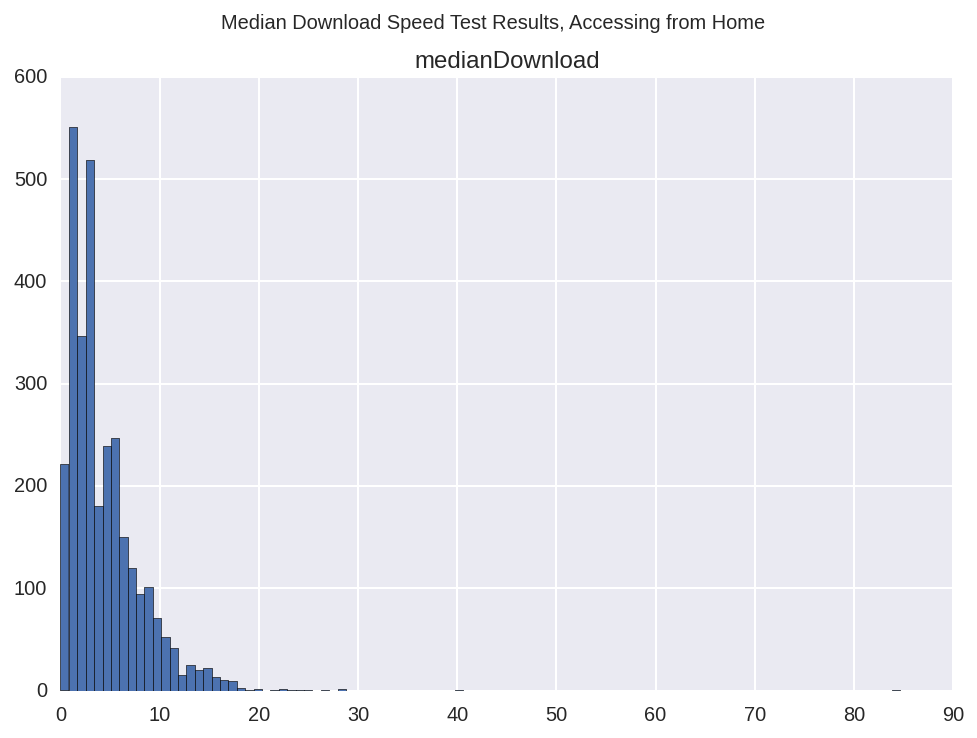

In [21]:
import pylab as pl
speed_testDF[speed_testDF['accessingFrom']=='Home'][['geographyId','medianDownload']].hist(bins=100)
pl.suptitle('Median Download Speed Test Results, Accessing from Home')
# p2=speed_testDF[speed_testDF['accessingFrom']=='Business'][['geographyId','medianDownload']].hist(bins=100)
# p3=speed_testDF[speed_testDF['accessingFrom']=='Mobile'][['geographyId','medianDownload']].hist(bins=100)

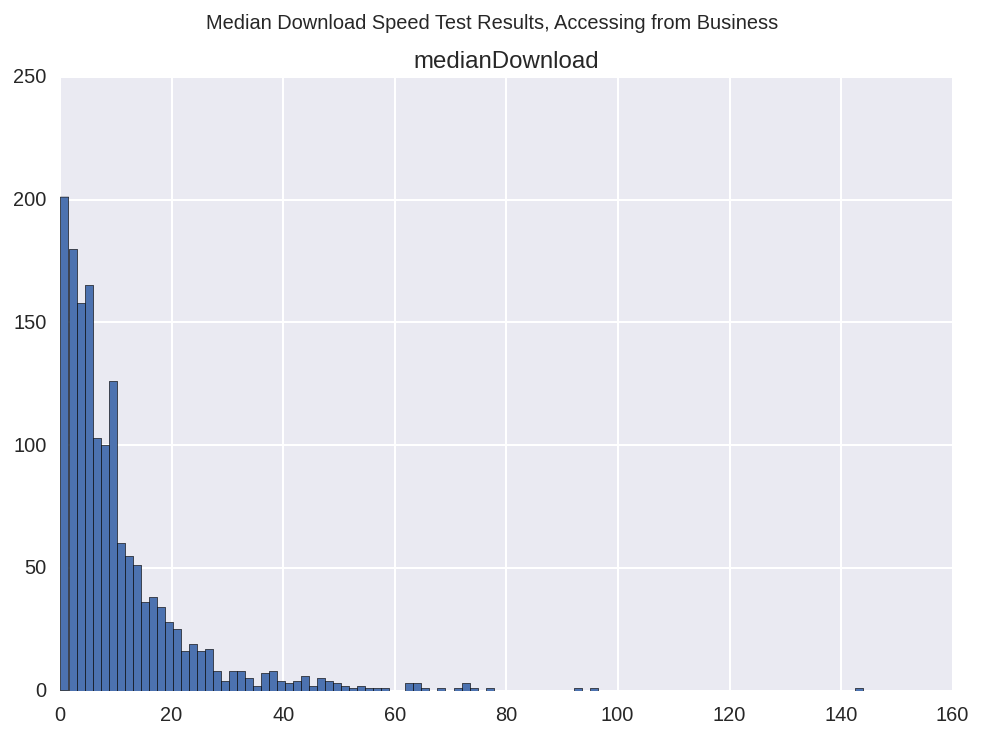

In [22]:
speed_testDF[speed_testDF['accessingFrom']=='Business'][['geographyId','medianDownload']].hist(bins=100)
pl.suptitle('Median Download Speed Test Results, Accessing from Business')

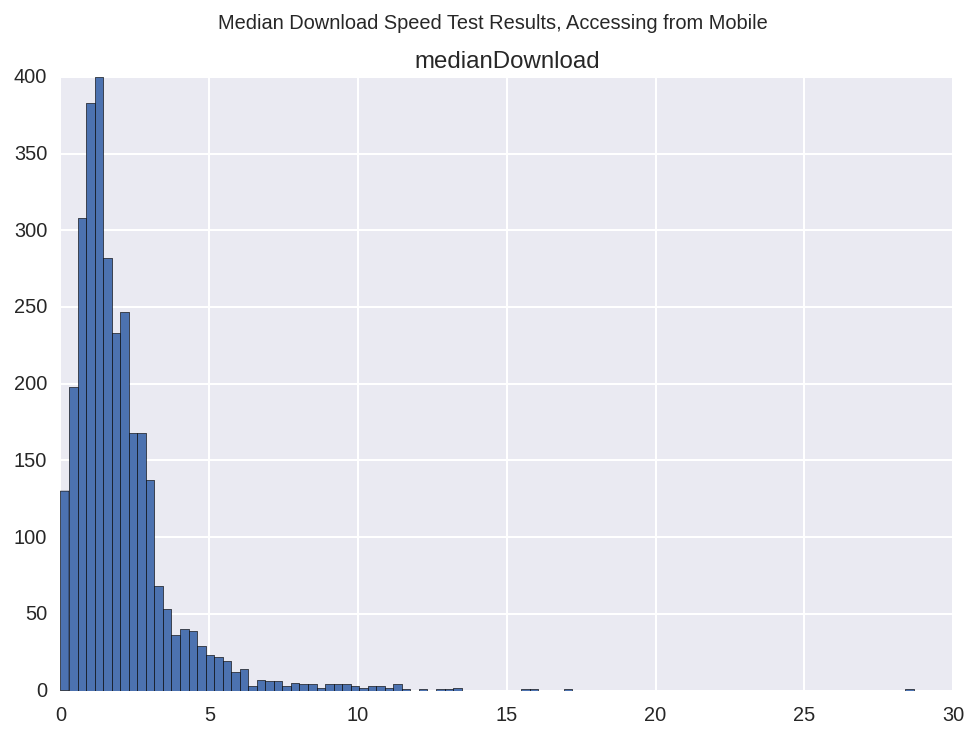

In [23]:
speed_testDF[speed_testDF['accessingFrom']=='Mobile'][['geographyId','medianDownload']].hist(bins=100)
pl.suptitle('Median Download Speed Test Results, Accessing from Mobile')

Median Home download rate by county exported, plot created in R and uploaded to github.
https://github.com/SethPaul/broadband-project/blob/master/media/medianHome.svg 

Poor quality import visible below.

In [24]:
from IPython.display import SVG, display
def show_svg():
    display(SVG(url='https://raw.githubusercontent.com/SethPaul/broadband-project/master/media/medianHome.svg'))
show_svg()

###Tried to switch to Vincent library to allow for inline ploting opposed to export to R.

In [25]:
sys.path.append('/usr/local/lib/python2.7/dist-packages') 
import vincent
import json
vincent.core.initialize_notebook()

In [26]:
county_topo='https://raw.githubusercontent.com/wrobstory/vincent_map_data/master/us_counties.topo.json'
geo_data = [{'name': 'counties',
             'url': county_topo,
             'feature': 'us_counties.geo'}]

vis = vincent.Map(data=speed_testDF[speed_testDF['accessingFrom']=='Home'], geo_data=geo_data, scale=1100, projection='albersUsa',
          data_bind='medianDownload', data_key='geographyId',
          map_key={'counties': 'properties.FIPS'})
vis.marks[0].properties.enter.stroke_opacity = vincent.ValueRef(value=0.5)
vis.to_json('vega.json',html_out=True,html_path='Counties_Population_choropleth.html')
vis.display()

### Able to use Vincent for visual feedback during analysis but likely finally deploy with D3 or R exported PNGs 

In [27]:
#Description of speeds for accessing from home from agreagated county info
speed_testDF[speed_testDF['accessingFrom']=='Home'].describe()

lowerQuartileDownload  lowerQuartileUpload  medianDownload  \
count            3065.000000          3065.000000     3065.000000   
mean                1.906076             0.472595        4.408705   
std                 1.899410             0.580190        3.926206   
min                 0.005610             0.002000        0.005610   
25%                 0.829190             0.271000        1.684750   
50%                 1.368980             0.383790        3.081060   
75%                 2.527130             0.533000        5.907230   
max                31.076170            22.117190       84.624030   

       medianUpload  numberOfTests  upperQuartileDownload  upperQuartileUpload  
count   3065.000000    3065.000000            3065.000000          3065.000000  
mean       0.869435     252.331158               8.737534             1.508684  
std        0.956406     950.382692               6.714085             1.651947  
min        0.012000       1.000000               0.005610             0.012000  
25%        0.421880       9.000000               3.071290             0.625980  
50%        0.616000      34.000000               6.882120             0.921880  
75%        0.926760     130.000000              13.503910             1.920900  
max       22.117190   27408.000000              94.682620            31.513000

In [28]:
#Description of speeds for accessing from business from aggreagated county info
speed_testDF[speed_testDF['accessingFrom']=='Business'].describe()

lowerQuartileDownload  lowerQuartileUpload  medianDownload  \
count            1534.000000          1534.000000     1534.000000   
mean                6.151323             2.994012       10.437275   
std                 9.425821             4.859423       12.113944   
min                 0.053710             0.025390        0.091300   
25%                 1.424080             0.785527        2.989260   
50%                 2.943850             1.440920        6.602050   
75%                 6.165035             2.929267       13.086090   
max                87.100590            67.693360      143.827150   

       medianUpload  numberOfTests  upperQuartileDownload  upperQuartileUpload  
count   1534.000000    1534.000000            1534.000000          1534.000000  
mean       5.037799      17.603651              17.130343             8.411053  
std        6.618418      54.550174              18.512301            10.937808  
min        0.058590       1.000000               0.091300             0.058590  
25%        1.373538       1.000000               4.681885             2.051642  
50%        3.068530       4.000000              11.798205             5.712890  
75%        6.188340      11.000000              23.574468            10.871583  
max      101.070800     840.000000             284.542970           200.442380

## Now to look at combining some Census data

In [29]:
#planning example call: http://api.census.gov/data/2015/pdb/blockgroup?get=County_name,State_name,Tot_Population_CEN_2010&for=block+group:*&in=state:01+county:001
urls=[]

# half the data of interest
#http://api.census.gov/data/2015/pdb/tract?get=County_name,State_name,County,LAND_AREA,Med_House_Value_ACS_09_13,Tot_Population_ACS_09_13,pct_Pop_18_24_ACS_09_13,pct_Pop_25_44_ACS_09_13&for tract:*state:01
urls.append('http://api.census.gov/data/2015/pdb/tract?get=County_name,State_name,County,LAND_AREA,Tot_Population_ACS_09_13,Aggregate_HH_INC_ACS_09_13,Aggr_House_Value_ACS_09_13&for=tract:*&in=state:01')

# other half
#http://api.census.gov/data/2015/pdb/tract?get=County_name,State_name,County,Tot_Occp_Units_ACS_09_13,Renter_Occp_HU_ACS_09_13,URBAN_CLUSTER_POP_CEN_2010,URBANIZED_AREA_POP_CEN_2010&for tract:*state:01
urls.append('http://api.census.gov/data/2015/pdb/tract?get=County_name,State_name,County,Tot_Occp_Units_ACS_09_13,Renter_Occp_HU_ACS_09_13,pct_Pop_18_24_ACS_09_13,pct_Pop_25_44_ACS_09_13,URBAN_CLUSTER_POP_CEN_2010,URBANIZED_AREA_POP_CEN_2010&for=tract:*&in=state:01')

session = FuturesSession(max_workers=15)

#Send multiple requests at once
future1 = session.get(urls[0])
future2 = session.get(urls[1]) 

In [30]:
response1=future1.result()
print response1.url
print response1.text[0:500]

http://api.census.gov/data/2015/pdb/tract?get=County_name,State_name,County,LAND_AREA,Tot_Population_ACS_09_13,Aggregate_HH_INC_ACS_09_13,Aggr_House_Value_ACS_09_13&for=tract:*&in=state:01
[["County_name","State_name","County","LAND_AREA","Tot_Population_ACS_09_13","Aggregate_HH_INC_ACS_09_13","Aggr_House_Value_ACS_09_13","state","county","tract"],
["Autauga County","Alabama","001","3.788","1808","$40,417,700","$80,532,000","01","001","020100"],
["Autauga County","Alabama","001","1.29","2355","$43,269,600","$91,182,000","01","001","020200"],
["Autauga County","Alabama","001","2.065","3057","$64,824,500","$123,226,000","01","001","020300"],
["Autauga County","Alabama","001","2.464"


In [31]:
response2=future2.result()
print response2.url
print response2.text[0:500]

http://api.census.gov/data/2015/pdb/tract?get=County_name,State_name,County,Tot_Occp_Units_ACS_09_13,Renter_Occp_HU_ACS_09_13,pct_Pop_18_24_ACS_09_13,pct_Pop_25_44_ACS_09_13,URBAN_CLUSTER_POP_CEN_2010,URBANIZED_AREA_POP_CEN_2010&for=tract:*&in=state:01
[["County_name","State_name","County","Tot_Occp_Units_ACS_09_13","Renter_Occp_HU_ACS_09_13","pct_Pop_18_24_ACS_09_13","pct_Pop_25_44_ACS_09_13","URBAN_CLUSTER_POP_CEN_2010","URBANIZED_AREA_POP_CEN_2010","state","county","tract"],
["Autauga County","Alabama","001","616","109","11.946902655","26.161504425","0","1594","01","001","020100"],
["Autauga County","Alabama","001","833","303","15.711252654","30.106157113","0","2170","01","001","020200"],
["Autauga County","Alabama","001","1153","212","8.11


In [32]:
county_fips.head()

state_abbrev  state_fp  county_fp      countyName fp_class_code  \
0           AL         1          1  Autauga County            H1   
1           AL         1          3  Baldwin County            H1   
2           AL         1          5  Barbour County            H1   
3           AL         1          7     Bibb County            H1   
4           AL         1          9   Blount County            H1   

   st_county_id st_county_id_str  
0          1001            01001  
1          1003            01003  
2          1005            01005  
3          1007            01007  
4          1009            01009

In [33]:
state_nums=set(county_fips['state_fp'].map("{:02}".format))
len(state_nums)

57

In [34]:
urls1=[]
base_url1='http://api.census.gov/data/2015/pdb/tract?get=County_name,State_name,County,LAND_AREA,Tot_Population_ACS_09_13,Aggregate_HH_INC_ACS_09_13,Aggr_House_Value_ACS_09_13,Tot_Housing_Units_ACS_09_13&for=tract:*&in=state:'
and_key='&key=77912556e5965544a3093efa3cb2305807fbe56c'
for state in state_nums:
    urls1.append(base_url1+state+and_key)

futures = [session.get(url) for url in urls1]
census_state_responses1 = [future.result() for future in futures]
   
#     

In [35]:
print urls1[0]
census_state_responses1[2].text[0:500]

http://api.census.gov/data/2015/pdb/tract?get=County_name,State_name,County,LAND_AREA,Tot_Population_ACS_09_13,Aggregate_HH_INC_ACS_09_13,Aggr_House_Value_ACS_09_13,Tot_Housing_Units_ACS_09_13&for=tract:*&in=state:30&key=77912556e5965544a3093efa3cb2305807fbe56c


u'[["County_name","State_name","County","LAND_AREA","Tot_Population_ACS_09_13","Aggregate_HH_INC_ACS_09_13","Aggr_House_Value_ACS_09_13","Tot_Housing_Units_ACS_09_13","state","county","tract"],\n["Adams County","Pennsylvania","001","21.14","2582","$81,288,700","$182,924,400","1014","42","001","030101"],\n["Adams County","Pennsylvania","001","26.313","5786","$171,055,700","$400,380,100","2347","42","001","030102"],\n["Adams County","Pennsylvania","001","46.78","5424","$128,766,400","$339,893,800","213'

In [36]:
census_stateDF_list1=[]
for census_state_response in census_state_responses1:
    braces_removed=re.sub('\[|]','',census_state_response.text)
    try:
        census_stateDF_list1.append(pd.read_csv(strIO(braces_removed), sep=","))
    except:
        print sys.exc_info

<built-in function exc_info>
<built-in function exc_info>
<built-in function exc_info>
<built-in function exc_info>
<built-in function exc_info>


In [37]:
len(census_stateDF_list1)

52

In [38]:
census_stateDF1=pd.concat(census_stateDF_list1)

In [39]:
urls2=[]
base_url2='http://api.census.gov/data/2015/pdb/tract?get=County_name,State_name,County,pct_Pop_18_24_ACS_09_13,pct_Pop_25_44_ACS_09_13,Tot_Occp_Units_ACS_09_13,Renter_Occp_HU_ACS_09_13,URBAN_CLUSTER_POP_CEN_2010,URBANIZED_AREA_POP_CEN_2010&for=tract:*&in=state:'
for state in state_nums:
    urls2.append(base_url2+state+and_key)

futures = [session.get(url) for url in urls2]
census_state_responses2 = [future.result() for future in futures]
 

In [40]:
census_state_responses2[0].text[0:500]

u'[["County_name","State_name","County","pct_Pop_18_24_ACS_09_13","pct_Pop_25_44_ACS_09_13","Tot_Occp_Units_ACS_09_13","Renter_Occp_HU_ACS_09_13","URBAN_CLUSTER_POP_CEN_2010","URBANIZED_AREA_POP_CEN_2010","state","county","tract"],\n["Beaverhead County","Montana","001","3.6170212766","17.80141844","723","223","0","0","30","001","000100"],\n["Beaverhead County","Montana","001","5.6166419019","19.108469539","1539","447","549","0","30","001","000200"],\n["Beaverhead County","Montana","001","22.007550522'

In [41]:
census_stateDF_list2=[]
for census_state_response in census_state_responses2:
    braces_removed=re.sub('\[|]','',census_state_response.text)
    try:
        census_stateDF_list2.append(pd.read_csv(strIO(braces_removed), sep=","))
    except:
        print sys.exc_info

<built-in function exc_info>
<built-in function exc_info>
<built-in function exc_info>
<built-in function exc_info>
<built-in function exc_info>


In [42]:
len(census_stateDF_list2)

52

In [43]:
census_stateDF2=pd.concat(census_stateDF_list2)

In [44]:
census_stateDF1.head()

County_name State_name  County LAND_AREA Tot_Population_ACS_09_13  \
0  Beaverhead County    Montana       1  4182.969                     1410   
1  Beaverhead County    Montana       1  1349.088                     3365   
2  Beaverhead County    Montana       1     9.566                     4503   
3    Big Horn County    Montana       3   863.016                     4792   
4    Big Horn County    Montana       3    925.53                     1713   

  Aggregate_HH_INC_ACS_09_13 Aggr_House_Value_ACS_09_13  \
0                $36,940,800               $166,544,400   
1                $77,467,800               $288,175,500   
2                $93,607,100               $155,268,800   
3                $88,363,700               $148,057,500   
4                $18,695,700                $34,051,000   

  Tot_Housing_Units_ACS_09_13  state  county   tract  Unnamed: 11  
0                        1352     30       1     100          NaN  
1                        1857     30       1     200          NaN  
2                        2044     30       1     300          NaN  
3                        1805     30       3     100          NaN  
4                         581     30       3  940400          NaN

In [45]:
census_stateDF1['unique_tract_id']=str(census_stateDF1['state'])+str(census_stateDF1['county'])+str(census_stateDF1['tract'])
census_stateDF2['unique_tract_id']=str(census_stateDF2['state'])+str(census_stateDF2['county'])+str(census_stateDF2['tract'])

census_stateDF1['st_county_id']=census_stateDF1['state']*1000+census_stateDF1['county']
census_stateDF2['st_county_id']=census_stateDF2['state']*1000+census_stateDF2['county']


In [46]:
output = open('census_stateDF1.pkl', 'wb')
pickle.dump(census_stateDF1, output)
output.close()

output = open('census_stateDF2.pkl', 'wb')
pickle.dump(census_stateDF2, output)
output.close()

In [47]:
import pickle
import pandas as pd

In [48]:
pkl_file = open('census_stateDF1.pkl', 'rb')
census_stateDF1 = pickle.load(pkl_file)

pkl_file = open('census_stateDF2.pkl', 'rb')
census_stateDF2 = pickle.load(pkl_file)

In [49]:
census_stateDF1.shape

(74004, 14)

In [50]:
census_stateDF2.shape

(74004, 15)

In [51]:
##DF1Columns "County_name","State_name","County","LAND_AREA","Tot_Population_ACS_09_13","pct_Pop_18_24_ACS_09_13","pct_Pop_25_44_ACS_09_13","Med_House_value_ACS_09_13","state","county","tract"
##DF2Columns "County_name","State_name","County","Tot_Occp_Units_ACS_09_13","Renter_Occp_HU_ACS_09_13","URBAN_CLUSTER_POP_CEN_2010","URBANIZED_AREA_POP_CEN_2010","state","county","tract"

# census_stateDF=pd.merge(census_stateDF1, census_stateDF2[['unique_tract_id',"Tot_Occp_Units_ACS_09_13","Renter_Occp_HU_ACS_09_13","URBAN_CLUSTER_POP_CEN_2010","URBANIZED_AREA_POP_CEN_2010"]],on='unique_tract_id')

In [52]:
import numpy as np
def num_convert(aString):
    try:
        if isinstance(aString,str) & (aString is not None):
            return float(re.sub('[$|,]','',aString.strip()))
        elif aString is None:
            return np.nan
        else:
            return float(aString)
    except ValueError,e:
        print aString is None
        print "error",e,"on line",aString

In [53]:
census_stateDF1['LAND_AREA']=census_stateDF1['LAND_AREA'].apply(num_convert)

False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null


In [54]:
census_stateDF1['Tot_Population_ACS_09_13']=census_stateDF1['Tot_Population_ACS_09_13'].apply(num_convert)

False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not convert string to float: null on line null
False
error could not con

In [55]:
census_stateDF1.to_csv('census_stateDF1.csv', sep=',',index=False)

In [56]:
census_stateDF1.shape

(74004, 14)

In [57]:
non_null_rows=census_stateDF1['Tot_Housing_Units_ACS_09_13']!='null'
census_stateDF1.loc[non_null_rows,'Tot_Housing_Units_ACS_09_13_num']=census_stateDF1['Tot_Housing_Units_ACS_09_13'][non_null_rows].fillna('nan').apply(num_convert)

In [58]:
# census_stateDF1['med_inc_sum']=census_stateDF1['Med_HHD_Inc_ACS_09_13'
non_null_rows=census_stateDF1['Aggregate_HH_INC_ACS_09_13']!='null'
census_stateDF1.loc[non_null_rows,'Aggregate_HH_INC_ACS_09_13_num']=census_stateDF1['Aggregate_HH_INC_ACS_09_13'][non_null_rows].fillna('nan').apply(num_convert)

In [59]:
non_null_rows=census_stateDF1['Aggr_House_Value_ACS_09_13']!='null'
census_stateDF1.loc[non_null_rows,'Aggr_House_Value_ACS_09_13_num']=census_stateDF1['Aggr_House_Value_ACS_09_13'][non_null_rows].fillna('nan').apply(num_convert)

In [60]:
census_stateDF1.head()

County_name State_name  County  LAND_AREA  Tot_Population_ACS_09_13  \
0  Beaverhead County    Montana       1   4182.969                      1410   
1  Beaverhead County    Montana       1   1349.088                      3365   
2  Beaverhead County    Montana       1      9.566                      4503   
3    Big Horn County    Montana       3    863.016                      4792   
4    Big Horn County    Montana       3    925.530                      1713   

  Aggregate_HH_INC_ACS_09_13 Aggr_House_Value_ACS_09_13  \
0                $36,940,800               $166,544,400   
1                $77,467,800               $288,175,500   
2                $93,607,100               $155,268,800   
3                $88,363,700               $148,057,500   
4                $18,695,700                $34,051,000   

  Tot_Housing_Units_ACS_09_13  state  county   tract  Unnamed: 11  \
0                        1352     30       1     100          NaN   
1                        1857     30       1     200          NaN   
2                        2044     30       1     300          NaN   
3                        1805     30       3     100          NaN   
4                         581     30       3  940400          NaN   

                                     unique_tract_id  st_county_id  \
0  0      30\n1      30\n2      30\n3      30\n4 ...         30001   
1  0      30\n1      30\n2      30\n3      30\n4 ...         30001   
2  0      30\n1      30\n2      30\n3      30\n4 ...         30001   
3  0      30\n1      30\n2      30\n3      30\n4 ...         30003   
4  0      30\n1      30\n2      30\n3      30\n4 ...         30003   

   Tot_Housing_Units_ACS_09_13_num  Aggregate_HH_INC_ACS_09_13_num  \
0                             1352                        36940800   
1                             1857                        77467800   
2                             2044                        93607100   
3                             1805                        88363700   
4                              581                        18695700   

   Aggr_House_Value_ACS_09_13_num  
0                       166544400  
1                       288175500  
2                       155268800  
3                       148057500  
4                        34051000

In [136]:
census_stateDF2.head()

County_name State_name  County pct_Pop_18_24_ACS_09_13  \
0  Beaverhead County    Montana       1                3.617021   
1  Beaverhead County    Montana       1                5.616642   
2  Beaverhead County    Montana       1                22.00755   
3    Big Horn County    Montana       3                7.241235   
4    Big Horn County    Montana       3                7.472271   

  pct_Pop_25_44_ACS_09_13 Tot_Occp_Units_ACS_09_13 Renter_Occp_HU_ACS_09_13  \
0                17.80142                      723                      223   
1                19.10847                     1539                      447   
2                 19.7646                     1848                      804   
3                19.61603                     1604                      518   
4                20.60712                      417                      151   

  URBAN_CLUSTER_POP_CEN_2010 URBANIZED_AREA_POP_CEN_2010  state  county  \
0                          0                           0     30       1   
1                        549                           0     30       1   
2                       4060                           0     30       1   
3                       3572                           0     30       3   
4                          0                           0     30       3   

    tract  Unnamed: 12                                    unique_tract_id  \
0     100          NaN  0      30\n1      30\n2      30\n3      30\n4 ...   
1     200          NaN  0      30\n1      30\n2      30\n3      30\n4 ...   
2     300          NaN  0      30\n1      30\n2      30\n3      30\n4 ...   
3     100          NaN  0      30\n1      30\n2      30\n3      30\n4 ...   
4  940400          NaN  0      30\n1      30\n2      30\n3      30\n4 ...   

   st_county_id  
0         30001  
1         30001  
2         30001  
3         30003  
4         30003

In [61]:
county_household=census_stateDF1[['st_county_id','Tot_Housing_Units_ACS_09_13_num','Aggregate_HH_INC_ACS_09_13_num', 'Aggr_House_Value_ACS_09_13_num']].groupby('st_county_id').sum()

In [62]:
county_household['AVG_HH_INC_ACS_09_1']=county_household.Aggregate_HH_INC_ACS_09_13_num/county_household.Tot_Housing_Units_ACS_09_13_num
county_household['AVG_House_Value_ACS_09_13']=county_household.Aggr_House_Value_ACS_09_13_num/county_household.Tot_Housing_Units_ACS_09_13_num
county_household.head()

Tot_Housing_Units_ACS_09_13_num  Aggregate_HH_INC_ACS_09_13_num  \
st_county_id                                                                    
1001                                    22220                      1298573600   
1003                                   104648                      4897889600   
1005                                    11790                       404116800   
1007                                     8939                       346641500   
1009                                    23767                      1157141900   

              Aggr_House_Value_ACS_09_13_num  AVG_HH_INC_ACS_09_1  \
st_county_id                                                        
1001                              2284014500         58441.656166   
1003                             11034378100         46803.470683   
1005                               933156200         34276.234097   
1007                               611481100         38778.554648   
1009                              2293187200         48686.914630   

              AVG_House_Value_ACS_09_13  
st_county_id                             
1001                      102790.931593  
1003                      105442.799671  
1005                       79148.108567  
1007                       68405.985010  
1009                       96486.186729

In [63]:
county_pop=census_stateDF1[['st_county_id','LAND_AREA', 'Tot_Population_ACS_09_13']].groupby('st_county_id').sum()


In [64]:
county_pop.head()

LAND_AREA  Tot_Population_ACS_09_13
st_county_id                                     
1001            594.437                     54907
1003           1589.786                    187114
1005            884.875                     27321
1007            622.581                     22754
1009            644.775                     57623

In [65]:
county_pop.describe()

LAND_AREA  Tot_Population_ACS_09_13
count    3221.000000               3221.000000
mean     1097.587443              97839.556349
std      3571.272054             312781.246887
min         1.998000                 71.000000
25%       418.923000              11252.000000
50%       604.362000              25975.000000
75%       914.524000              66015.000000
max    145504.790000            9888786.000000

In [66]:
county_pop['county_pop_density']=county_pop['Tot_Population_ACS_09_13'].astype(float)/county_pop['LAND_AREA'].astype(float)

In [67]:
county_pop=county_pop.reset_index()

In [68]:
def add_leading_zeros(st_c_id):
    return str(st_c_id).zfill(5)

county_pop['geoID']=county_pop['st_county_id'].apply(add_leading_zeros)
county_pop.head()

st_county_id  LAND_AREA  Tot_Population_ACS_09_13  county_pop_density  \
0          1001    594.437                     54907           92.368073   
1          1003   1589.786                    187114          117.697602   
2          1005    884.875                     27321           30.875547   
3          1007    622.581                     22754           36.547855   
4          1009    644.775                     57623           89.369160   

   geoID  
0  01001  
1  01003  
2  01005  
3  01007  
4  01009

In [69]:
county_topo='https://raw.githubusercontent.com/wrobstory/vincent_map_data/master/us_counties.topo.json'
geo_data = [{'name': 'counties',
             'url': county_topo,
             'feature': 'us_counties.geo'}]

vis = vincent.Map(data=county_pop, geo_data=geo_data, scale=1100, projection='albersUsa',
          data_bind='county_pop_density', data_key='geoID',
          map_key={'counties': 'properties.FIPS'})
vis.marks[0].properties.enter.stroke_opacity = vincent.ValueRef(value=0.5)
vis.to_json('vega.json',html_out=True,html_path='Counties_Population_choropleth.html')
vis.display()

In [70]:
county_census=pd.merge(county_pop, county_household.reset_index()[['st_county_id','Tot_Housing_Units_ACS_09_13_num','AVG_HH_INC_ACS_09_1','AVG_House_Value_ACS_09_13' ]])

In [71]:
county_census['housing_density']=county_census.Tot_Housing_Units_ACS_09_13_num/county_census.LAND_AREA
county_census.head()

st_county_id  LAND_AREA  Tot_Population_ACS_09_13  county_pop_density  \
0          1001    594.437                     54907           92.368073   
1          1003   1589.786                    187114          117.697602   
2          1005    884.875                     27321           30.875547   
3          1007    622.581                     22754           36.547855   
4          1009    644.775                     57623           89.369160   

   geoID  Tot_Housing_Units_ACS_09_13_num  AVG_HH_INC_ACS_09_1  \
0  01001                            22220         58441.656166   
1  01003                           104648         46803.470683   
2  01005                            11790         34276.234097   
3  01007                             8939         38778.554648   
4  01009                            23767         48686.914630   

   AVG_House_Value_ACS_09_13  housing_density  
0              102790.931593        37.379907  
1              105442.799671        65.825212  
2               79148.108567        13.323916  
3               68405.985010        14.357971  
4               96486.186729        36.860920

##Add econ data

In [72]:
industry_codes_2digit=pd.read_table(os.getcwd()+'/refs/NAICS_2digit.txt',index_col=False, sep=';')
industry_codes_2digit['NAICS_2digit']=industry_codes_2digit['NAICS_2digit'].astype(str)
industry_codes_2digit

NAICS_2digit                                     Industry_Group
0            11         Agriculture, Forestry, Fishing and Hunting
1            21      Mining, Quarrying, and Oil and Gas Extraction
2            22                                          Utilities
3            23                                       Construction
4            31                                      Manufacturing
5            32                                      Manufacturing
6            33                                      Manufacturing
7            42                                    Wholesale Trade
8            44                                       Retail Trade
9            45                                       Retail Trade
10           48                     Transportation and Warehousing
11           49                     Transportation and Warehousing
12           51                                        Information
13           52                              Finance and Insurance
14           53                 Real Estate and Rental and Leasing
15           54      Professional, Scientific, and Technical Se...
16           55            Management of Companies and Enterprises
17           56      Administrative and Support and Waste Manag...
18           61                               Educational Services
19           62                  Health Care and Social Assistance
20           71                Arts, Entertainment, and Recreation
21           72                    Accommodation and Food Services
22           81      Other Services (except Public Administration)
23           92                              Public Administration

In [73]:
industry_codes=pd.read_excel(os.getcwd()+'/refs/6-digit_2012_Codes.xls',sheetname='2012_6-digit_industries',index_col=False, sep=';')
print industry_codes.shape
industry_codes.columns=['NAICS2012','Industry_Desc']
industry_codes=industry_codes.drop(industry_codes.index[0]) #remove empty row
industry_codes['NAICS2012']=industry_codes['NAICS2012'].astype(int).astype(str)
industry_codes.head()

(1066, 2)


NAICS2012                      Industry_Desc
1    111110                    Soybean Farming
2    111120  Oilseed (except Soybean) Farming 
3    111130          Dry Pea and Bean Farming 
4    111140                      Wheat Farming
5    111150                      Corn Farming

In [74]:
column_names=re.split(',', 'CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX')
base_url='http://api.census.gov/data/2012/ewks?get=CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX&for=county:*&&NAICS2012='
and_key='&key=77912556e5965544a3093efa3cb2305807fbe56c'
session = FuturesSession(max_workers=15)
urls=[]
for industry in industry_codes['NAICS2012']:
    urls.append(base_url+industry.strip()+and_key)
#     print base_url+industry+and_key
    
#Send multiple requests at once
futures = [session.get(url) for url in urls]
industry_responses = [future.result() for future in futures]

In [75]:
from StringIO import StringIO as strIO 

In [76]:
industryDFs=[]
for industry_response in industry_responses:
    try:
        braces_removed=re.sub('\[|]','',industry_response.text)
        industryDFs.append(pd.read_csv(strIO(braces_removed), sep=","))
    except:
        1 #print 'no data for an industry'

industryDF=pd.concat(industryDFs)

In [77]:
industryDF.shape

(444402, 13)

In [78]:
industryDF['NAICS2012']=industryDF['NAICS2012'].astype(str)

In [79]:
industryDF['NAICS_2digit']=industryDF['NAICS2012'].apply(lambda x: x[0:2])
industryDF['NAICS_2digit'].head()

0    22
1    22
2    22
3    22
4    22
Name: NAICS_2digit, dtype: object

In [80]:
industryDF=pd.merge(industryDF, industry_codes, on='NAICS2012' )
industryDF.shape

(444402, 15)

In [81]:
industryDF=pd.merge(industryDF,industry_codes_2digit, on='NAICS_2digit')
industryDF.tail()

CSA  ST  COUNTY NAICS2012  EMP  RCPTOT  PAYANN  ESTAB OPTAX  \
444397  999  56      37    812990    0       0       0      1     T   
444398  999  56      39    812990    0       0       0      4     A   
444399  999  56      39    812990    0       0       0      4     T   
444400  999  56      41    812990    0       0       0      1     A   
444401  999  56      41    812990    0       0       0      1     T   

        NAICS2012.1  state  county  Unnamed: 12 NAICS_2digit  \
444397       812990     56      37          NaN           81   
444398       812990     56      39          NaN           81   
444399       812990     56      39          NaN           81   
444400       812990     56      41          NaN           81   
444401       812990     56      41          NaN           81   

                       Industry_Desc  \
444397  All Other Personal Services    
444398  All Other Personal Services    
444399  All Other Personal Services    
444400  All Other Personal Services    
444401  All Other Personal Services    

                                           Industry_Group  
444397      Other Services (except Public Administration)  
444398      Other Services (except Public Administration)  
444399      Other Services (except Public Administration)  
444400      Other Services (except Public Administration)  
444401      Other Services (except Public Administration)

In [82]:
industryDF.NAICS_2digit.value_counts()

42    61339
44    54774
62    53736
54    46515
81    34218
45    23952
72    23623
71    20403
52    19028
48    18133
53    18111
56    17649
33    13113
61    11437
51     9300
32     7110
22     5407
31     3364
49     3190
dtype: int64

In [83]:
industryDF['st_county_id']= industryDF['ST']*1000+industryDF['COUNTY']
industryDF=pd.merge(industryDF, county_fips, on='st_county_id' )
industryDF['Industry_Group']=industryDF['Industry_Group'].apply(lambda x: x.strip())

In [84]:
by_ST=industryDF[['state_abbrev','Industry_Group', 'EMP','RCPTOT','PAYANN']].groupby(['state_abbrev']).sum()

In [85]:
by_ST.head()

EMP      RCPTOT     PAYANN
state_abbrev                                 
AK              112359    16103745    4740814
AL              350277    65987690   10396297
AR               97564    11821734    1821407
AZ             1271948   209266067   51602673
CA            11393870  2088402872  561608049

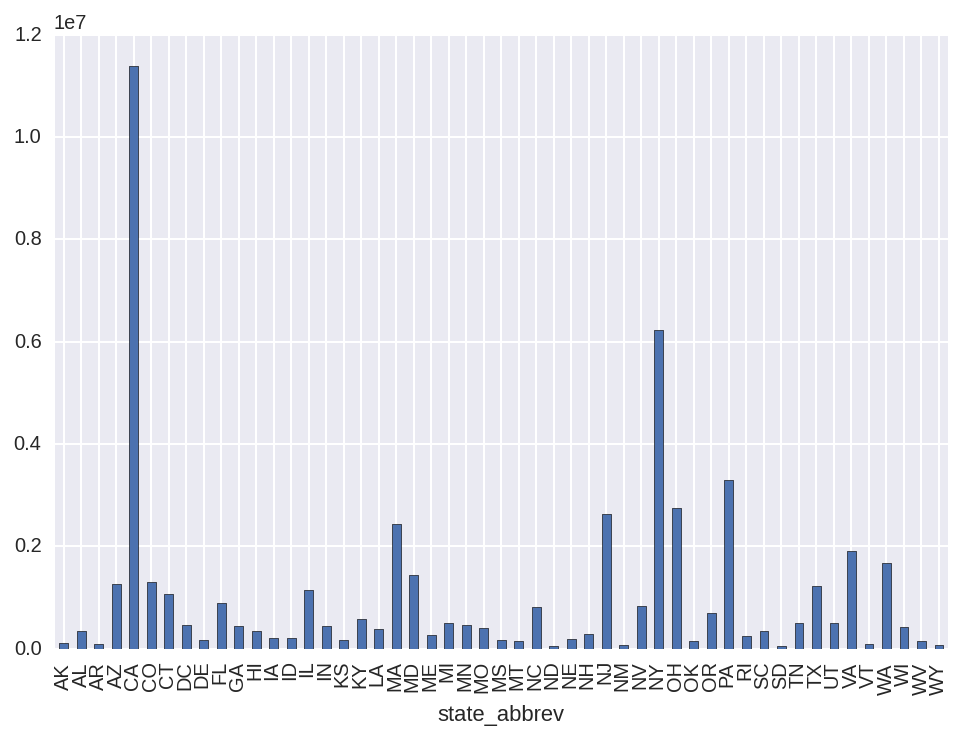

In [86]:
p1=by_ST['EMP'].plot(kind='bar')

In [87]:
by_county=industryDF[['st_county_id','Industry_Group', 'EMP','RCPTOT','PAYANN']].groupby(['st_county_id','Industry_Group']).sum()

In [88]:
by_county.head()

EMP  RCPTOT  PAYANN
st_county_id Industry_Group                                         
1001         Accommodation and Food Services     888   32462   11184
             Finance and Insurance               242       0    8877
             Manufacturing                         0       0       0
             Real Estate and Rental and Leasing   36    5139     906
             Retail Trade                        305  127404    5802

In [89]:
by_county_sum=by_county.reset_index().groupby('st_county_id').sum()

In [90]:
by_county_sum.columns=['tot_county_emp', 'tot_county_rcp', 'tot_county_ann_pay']
by_county_sum.head()

tot_county_emp  tot_county_rcp  tot_county_ann_pay
st_county_id                                                    
1001                    1483          166297               27014
1003                   20375         3223110              447324
1005                    1238          180526               28864
1007                     191           30030                3062
1009                     755           76132               14648

In [91]:
county_propDF=pd.merge(by_county.reset_index(), by_county_sum.reset_index(), on='st_county_id' )

In [92]:
county_propDF['ind_prop_county_emp']=county_propDF.EMP*1.0/county_propDF.tot_county_emp
county_propDF['ind_prop_county_rcp']=county_propDF.RCPTOT*1.0/county_propDF.tot_county_rcp
county_propDF['ind_prop_county_pay']=county_propDF.PAYANN*1.0/county_propDF.tot_county_ann_pay

county_propDF.head()

st_county_id                      Industry_Group  EMP  RCPTOT  PAYANN  \
0          1001     Accommodation and Food Services  888   32462   11184   
1          1001               Finance and Insurance  242       0    8877   
2          1001                       Manufacturing    0       0       0   
3          1001  Real Estate and Rental and Leasing   36    5139     906   
4          1001                        Retail Trade  305  127404    5802   

   tot_county_emp  tot_county_rcp  tot_county_ann_pay  ind_prop_county_emp  \
0            1483          166297               27014             0.598786   
1            1483          166297               27014             0.163183   
2            1483          166297               27014             0.000000   
3            1483          166297               27014             0.024275   
4            1483          166297               27014             0.205664   

   ind_prop_county_rcp  ind_prop_county_pay  
0             0.195205             0.414008  
1             0.000000             0.328607  
2             0.000000             0.000000  
3             0.030903             0.033538  
4             0.766123             0.214778

In [196]:
county_ind_prop_pivot=county_propDF[[ \
                                     'st_county_id',
                                     'Industry_Group',
                                     'ind_prop_county_emp',
                                     'ind_prop_county_rcp',
                                     'ind_prop_county_pay']]\
                                    .pivot(index='st_county_id', columns='Industry_Group')

In [197]:
county_ind_prop_pivot.head()

ind_prop_county_emp  \
Industry_Group Accommodation and Food Services   
st_county_id                                     
1001                                  0.598786   
1003                                  0.430920   
1005                                  0.373183   
1007                                  0.481675   
1009                                  0.558940   

                                                                                         \
Industry_Group Administrative and Support and Waste Management and Remediation Services   
st_county_id                                                                              
1001                                                          NaN                         
1003                                                          NaN                         
1005                                                          NaN                         
1007                                                          NaN                         
1009                                                          NaN                         

                                                                         \
Industry_Group Arts, Entertainment, and Recreation Educational Services   
st_county_id                                                              
1001                                           NaN                  NaN   
1003                                           NaN                  NaN   
1005                                           NaN                  NaN   
1007                                           NaN                  NaN   
1009                                           NaN                  NaN   

                                                                        \
Industry_Group Finance and Insurance Health Care and Social Assistance   
st_county_id                                                             
1001                        0.163183                               NaN   
1003                        0.059239                               NaN   
1005                        0.121971                               NaN   
1007                        0.000000                               NaN   
1009                        0.188079                               NaN   

                                          \
Industry_Group Information Manufacturing   
st_county_id                               
1001                   NaN      0.000000   
1003                   NaN      0.006086   
1005                   NaN      0.000000   
1007                   NaN           NaN   
1009                   NaN      0.011921   

                                                              \
Industry_Group Other Services (except Public Administration)   
st_county_id                                                   
1001                                                     NaN   
1003                                                     NaN   
1005                                                     NaN   
1007                                                     NaN   
1009                                                     NaN   

                                                                 \
Industry_Group Professional, Scientific, and Technical Services   
st_county_id                                                      
1001                                                        NaN   
1003                                                        NaN   
1005                                                        NaN   
1007                                                        NaN   
1009                                                        NaN   

                     ...                     ind_prop_county_pay              \
Industry_Group       ...       Health Care and Social Assistance Information   
st_county_id         ...                                                       
1001                 ...                                    

In [198]:
county_ind_prop_pivot=county_ind_prop_pivot.fillna(0)
county_ind_prop_pivot.head()

ind_prop_county_emp  \
Industry_Group Accommodation and Food Services   
st_county_id                                     
1001                                  0.598786   
1003                                  0.430920   
1005                                  0.373183   
1007                                  0.481675   
1009                                  0.558940   

                                                                                         \
Industry_Group Administrative and Support and Waste Management and Remediation Services   
st_county_id                                                                              
1001                                                            0                         
1003                                                            0                         
1005                                                            0                         
1007                                                            0                         
1009                                                            0                         

                                                                         \
Industry_Group Arts, Entertainment, and Recreation Educational Services   
st_county_id                                                              
1001                                             0                    0   
1003                                             0                    0   
1005                                             0                    0   
1007                                             0                    0   
1009                                             0                    0   

                                                                        \
Industry_Group Finance and Insurance Health Care and Social Assistance   
st_county_id                                                             
1001                        0.163183                                 0   
1003                        0.059239                                 0   
1005                        0.121971                                 0   
1007                        0.000000                                 0   
1009                        0.188079                                 0   

                                          \
Industry_Group Information Manufacturing   
st_county_id                               
1001                     0      0.000000   
1003                     0      0.006086   
1005                     0      0.000000   
1007                     0      0.000000   
1009                     0      0.011921   

                                                              \
Industry_Group Other Services (except Public Administration)   
st_county_id                                                   
1001                                                       0   
1003                                                       0   
1005                                                       0   
1007                                                       0   
1009                                                       0   

                                                                 \
Industry_Group Professional, Scientific, and Technical Services   
st_county_id                                                      
1001                                                          0   
1003                                                          0   
1005                                                          0   
1007                                                          0   
1009                                                          0   

                     ...                     ind_prop_county_pay              \
Industry_Group       ...       Health Care and Social Assistance Information   
st_county_id         ...                                                       
1001                 ...                                    

In [199]:
county_ind_prop_pivot.shape

(3140, 45)

In [97]:
from sklearn import cluster, mixture
from sklearn import metrics

In [98]:
km_ind_2=cluster.KMeans(n_clusters=2,n_init=20).fit(county_ind_prop_pivot)
km_ind_3=cluster.KMeans(n_clusters=3,n_init=20).fit(county_ind_prop_pivot)
km_ind_4=cluster.KMeans(n_clusters=4,n_init=20).fit(county_ind_prop_pivot)
km_ind_5=cluster.KMeans(n_clusters=5,n_init=20).fit(county_ind_prop_pivot)
km_ind_6=cluster.KMeans(n_clusters=8,n_init=20).fit(county_ind_prop_pivot)
km_ind_7=cluster.KMeans(n_clusters=12,n_init=20).fit(county_ind_prop_pivot)
km_ind_8=cluster.KMeans(n_clusters=16,n_init=20).fit(county_ind_prop_pivot)
km_ind_9=cluster.KMeans(n_clusters=24,n_init=20).fit(county_ind_prop_pivot)
km_ind_10=cluster.KMeans(n_clusters=40,n_init=20).fit(county_ind_prop_pivot)


In [99]:
kmean_test=pd.DataFrame([
        ("KM 2 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_2.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 3 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_3.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 4 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_4.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 5 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_5.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 6 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_6.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 7 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_7.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 8 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_8.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 9 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_9.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 10 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_10.predict(county_ind_prop_pivot), metric='euclidean'))
], columns=["Model", "Silhouette"])

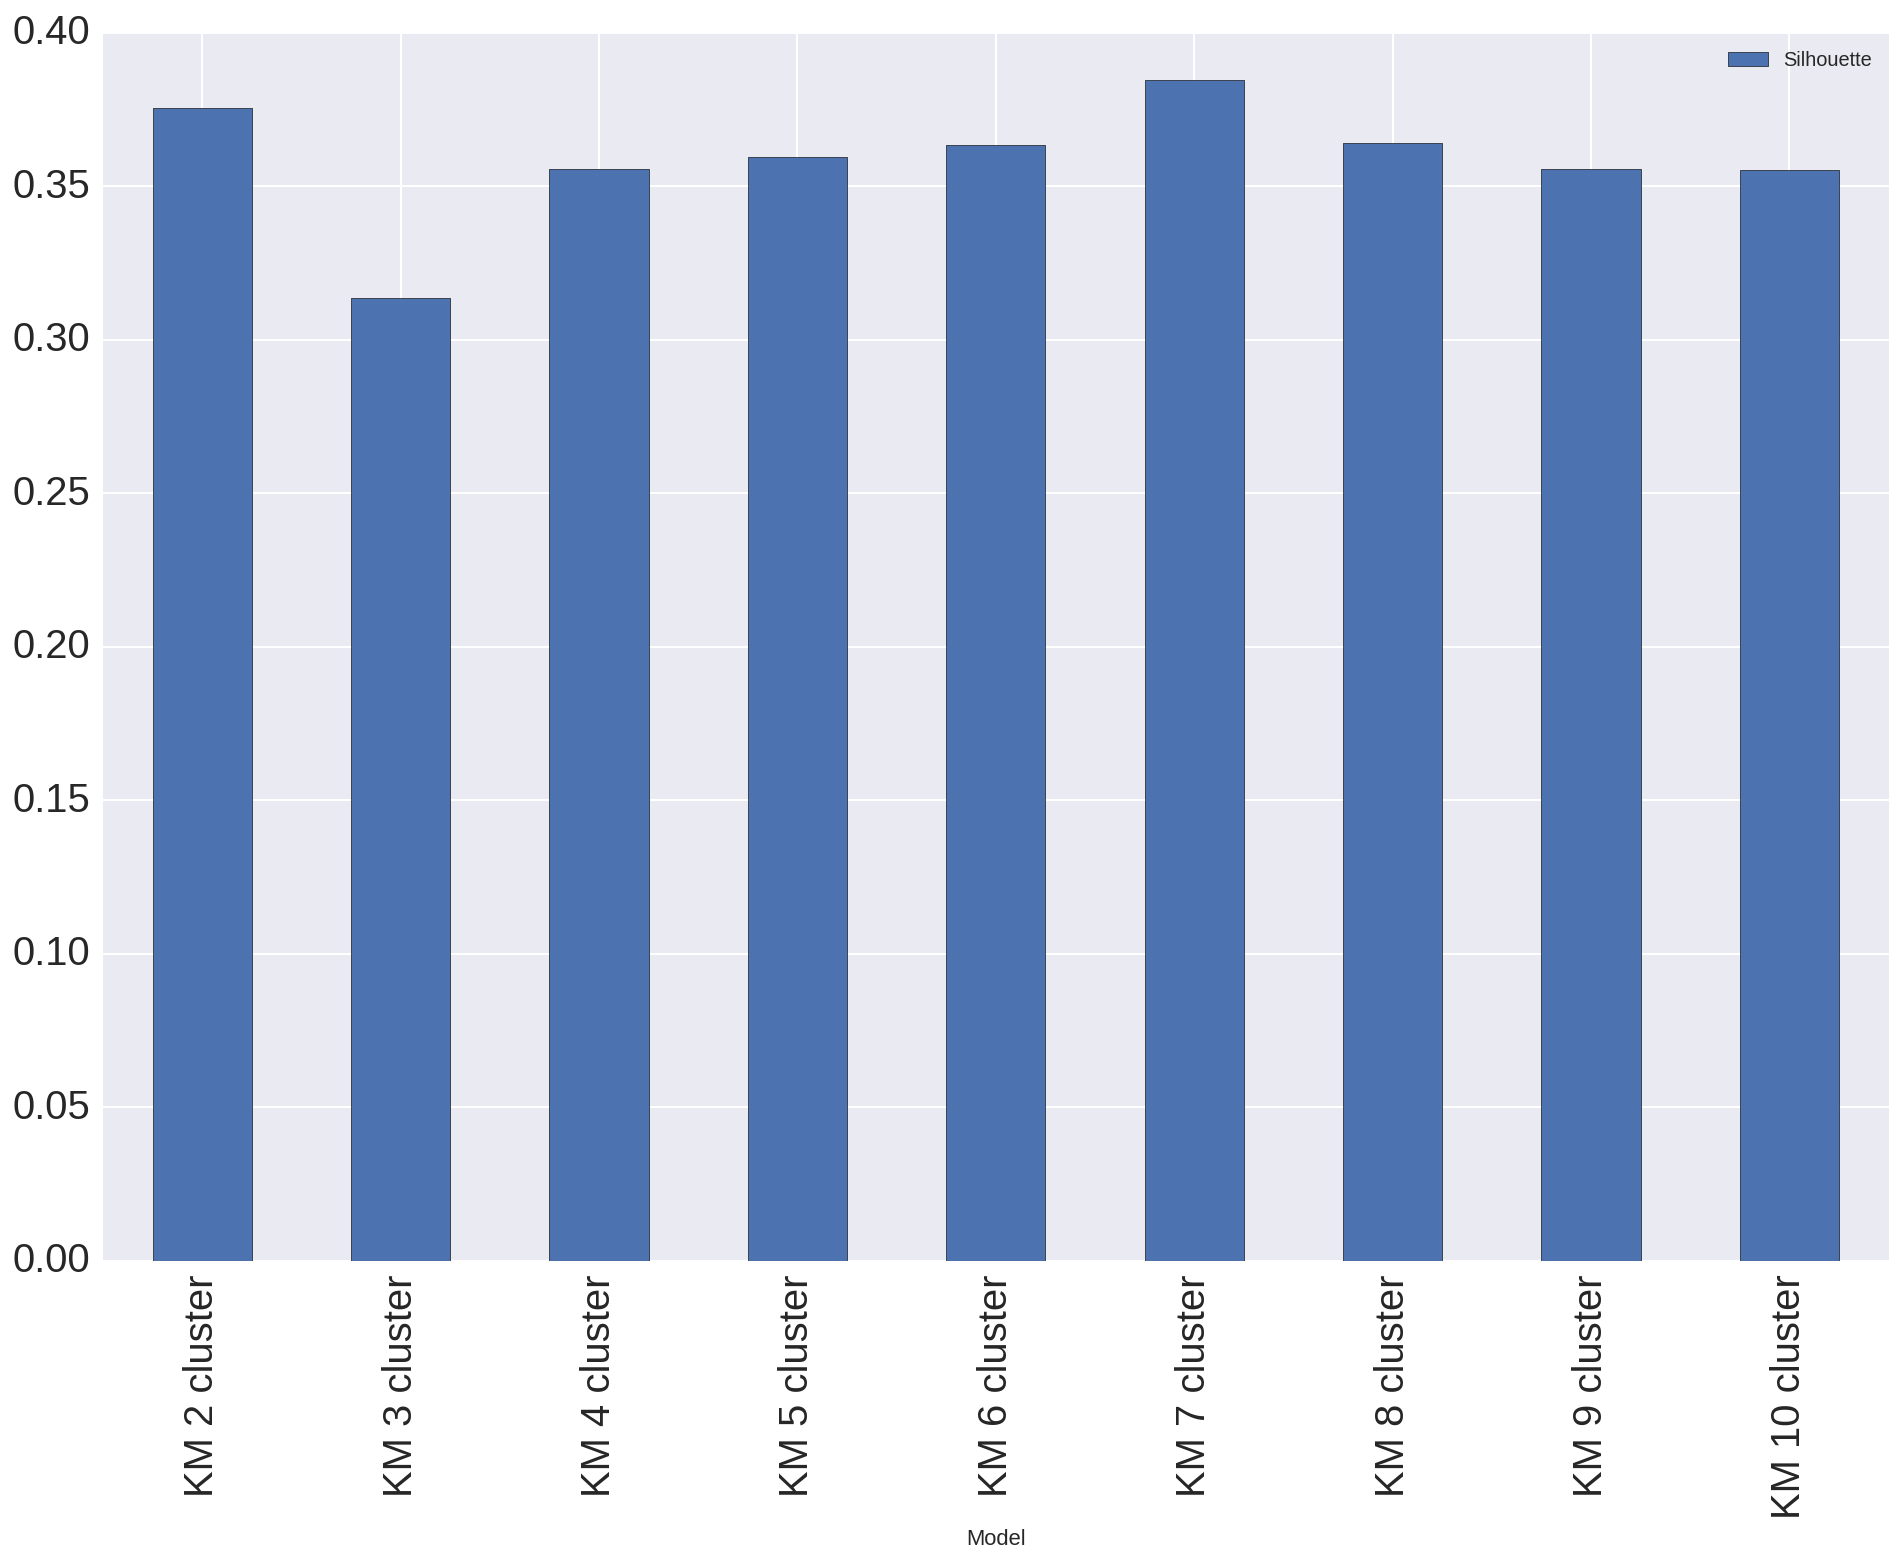

In [100]:
p1=kmean_test.plot(x="Model", y="Silhouette", kind="bar", figsize=(16,11),fontsize=20)
p1

In [101]:
gmm_ind_2=mixture.GMM(n_components=2,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_3=mixture.GMM(n_components=3,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_4=mixture.GMM(n_components=4,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_5=mixture.GMM(n_components=5,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_6=mixture.GMM(n_components=6,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_7=mixture.GMM(n_components=7,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_8=mixture.GMM(n_components=8,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_9=mixture.GMM(n_components=9,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_10=mixture.GMM(n_components=10,n_init=20).fit(county_ind_prop_pivot)

In [102]:
gmm_test=pd.DataFrame([
        ("GMM 2 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_2.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 3 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_3.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 4 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_4.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 5 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_5.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 6 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_6.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 7 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_7.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 8 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_8.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 9 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_9.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 10 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_10.predict(county_ind_prop_pivot), metric='euclidean')),
        
    ], columns=["Model", "Silhouette"])

In [103]:
emp_by_industry=industryDF[['Industry_Group', 'EMP']].groupby('Industry_Group')

Industry_Group  Industry_tot_emp
0                    Accommodation and Food Services          10319062
1  Administrative and Support and Waste Managemen...           2873452
2                Arts, Entertainment, and Recreation           1098810
3                               Educational Services            445487
4                              Finance and Insurance           2392204

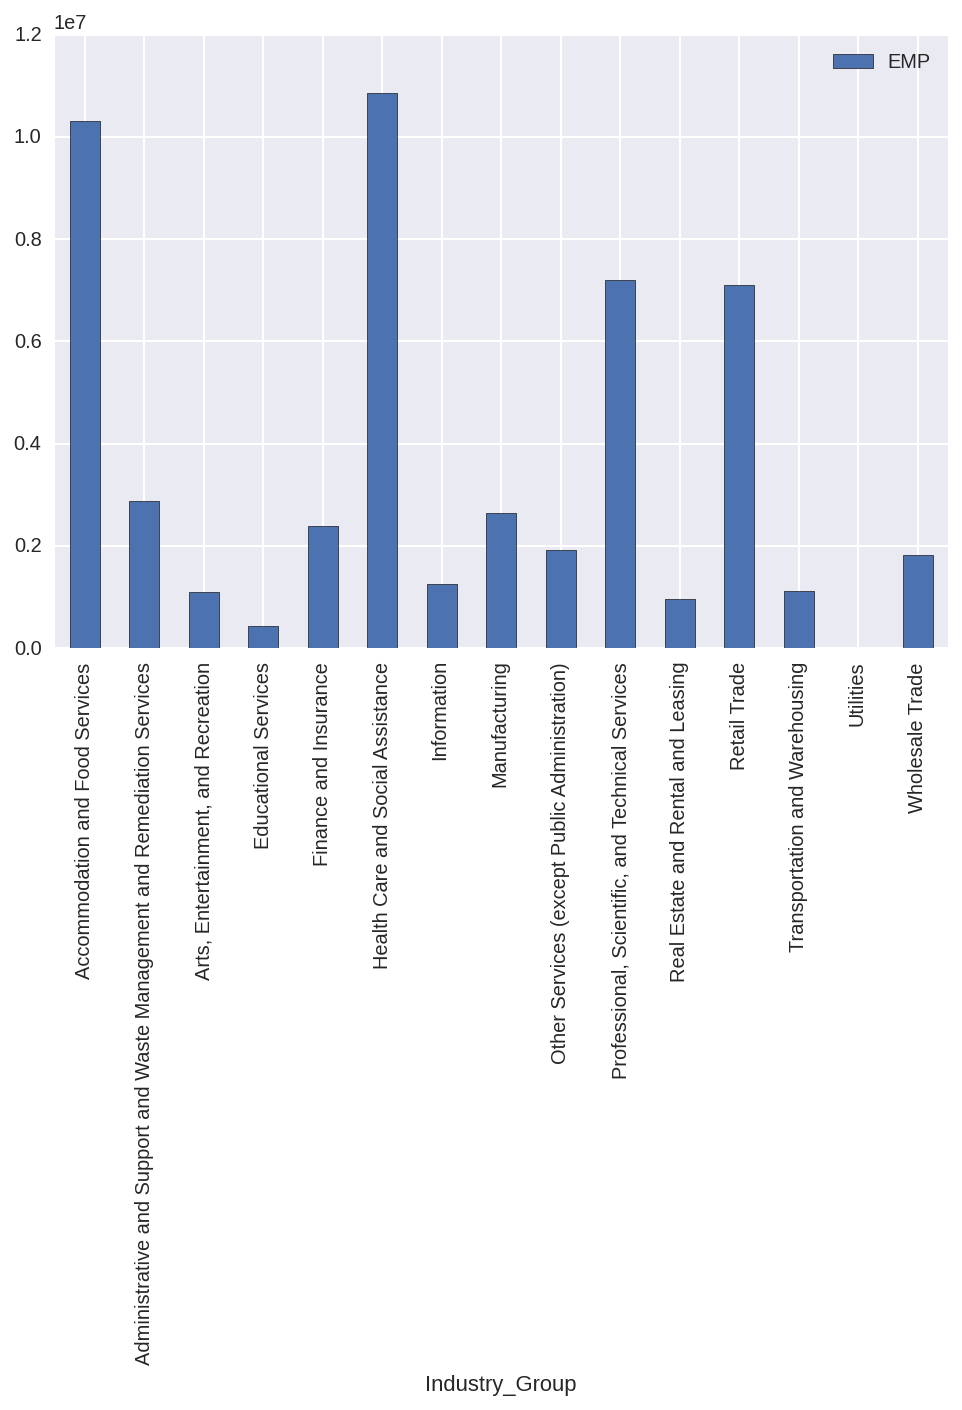

In [104]:
workforce_by_industry=emp_by_industry.sum()
workforce_by_industry.plot(kind='bar')
workforce_by_industry=workforce_by_industry.reset_index()
workforce_by_industry.columns=['Industry_Group', 'Industry_tot_emp']
workforce_by_industry.head()

## Now combine it all together- At-home consumers first
We'll consider the population statistics with the broadband information by county

In [105]:
from sklearn import linear_model, preprocessing, cross_validation

In [106]:
output = open('county_census.pkl', 'wb')
pickle.dump(county_census, output)
output.close()

In [107]:
output = open('speed_testDF.pkl', 'wb')
pickle.dump(speed_testDF, output)
output.close()

In [108]:
output = open('county_ind_prop_pivot.pkl', 'wb')
pickle.dump(county_ind_prop_pivot, output)
output.close()

In [109]:
census_features=county_census[['geoID','county_pop_density',\
                                       'AVG_HH_INC_ACS_09_1',\
                                       'AVG_House_Value_ACS_09_13',\
                                       'housing_density']].dropna(axis=0)
census_features.head()

geoID  county_pop_density  AVG_HH_INC_ACS_09_1  AVG_House_Value_ACS_09_13  \
0  01001           92.368073         58441.656166              102790.931593   
1  01003          117.697602         46803.470683              105442.799671   
2  01005           30.875547         34276.234097               79148.108567   
3  01007           36.547855         38778.554648               68405.985010   
4  01009           89.369160         48686.914630               96486.186729   

   housing_density  
0        37.379907  
1        65.825212  
2        13.323916  
3        14.357971  
4        36.860920

In [110]:
speed_labels=speed_testDF[['geographyId','medianDownload','medianUpload']][speed_testDF['accessingFrom']=='Home'].dropna(axis=0)
speed_labels.head()

geographyId  medianDownload  medianUpload
0        01001         4.97324       1.03272
5        01003         2.76063       0.64941
10       01005         7.14257       0.48700
14       01007         2.69141       0.52800
18       01009         2.15430       0.41895

In [178]:
for_home_model=pd.merge(census_features,speed_labels, left_on='geoID', right_on='geographyId').dropna(axis=0)
for_home_model.head()

geoID  county_pop_density  AVG_HH_INC_ACS_09_1  AVG_House_Value_ACS_09_13  \
0  01001           92.368073         58441.656166              102790.931593   
1  01003          117.697602         46803.470683              105442.799671   
2  01005           30.875547         34276.234097               79148.108567   
3  01007           36.547855         38778.554648               68405.985010   
4  01009           89.369160         48686.914630               96486.186729   

   housing_density geographyId  medianDownload  medianUpload  
0        37.379907       01001         4.97324       1.03272  
1        65.825212       01003         2.76063       0.64941  
2        13.323916       01005         7.14257       0.48700  
3        14.357971       01007         2.69141       0.52800  
4        36.860920       01009         2.15430       0.41895

In [200]:
county_ind_prop_pivot=county_ind_prop_pivot.reset_index()

In [201]:
county_ind_prop_pivot['geoID']=county_ind_prop_pivot['st_county_id'].apply(lambda x: '%05d'%x)
county_ind_prop_pivot['geoID'].head()
# cats

0    01001
1    01003
2    01005
3    01007
4    01009
Name: geoID, dtype: object

In [202]:
county_ind_prop_pivot.columns= [' '.join(col).strip() for col in county_ind_prop_pivot.columns.values]

In [186]:
# county_ind_prop_pivot.columns =county_ind_prop_pivot.columns.get_level_values(0)

In [203]:
county_ind_prop_pivot.head()

st_county_id  ind_prop_county_emp Accommodation and Food Services  \
0          1001                                           0.598786     
1          1003                                           0.430920     
2          1005                                           0.373183     
3          1007                                           0.481675     
4          1009                                           0.558940     

   ind_prop_county_emp Administrative and Support and Waste Management and Remediation Services  \
0                                                  0                                              
1                                                  0                                              
2                                                  0                                              
3                                                  0                                              
4                                                  0                                              

   ind_prop_county_emp Arts, Entertainment, and Recreation  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   ind_prop_county_emp Educational Services  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   ind_prop_county_emp Finance and Insurance  \
0                                   0.163183   
1                                   0.059239   
2                                   0.121971   
3                                   0.000000   
4                                   0.188079   

   ind_prop_county_emp Health Care and Social Assistance  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   ind_prop_county_emp Information  ind_prop_county_emp Manufacturing  \
0                                0                           0.000000   
1                                0                           0.006086   
2                                0                           0.000000   
3                                0                           0.000000   
4                                0                           0.011921   

   ind_prop_county_emp Other Services (except Public Administration)  ...    \
0                                                  0                  ...     
1                                                  0                  ...     
2                                                  0                  ...     
3                                                  0                  ...     
4                                                  0                  ...     

   ind_prop_county_pay Information  ind_prop_county_pay Manufacturing  \
0                                0                           0.000000   
1                                0                           0.011479   
2                                0                           0.000000   
3                                0                           0.000000   
4                                0                           0.000000   

   ind_prop_county_pay Other Services (except Public Administration)  \
0                                                  0                   
1                                                  0                   
2                                                  0                   
3                           

In [189]:
# temp_names= [' '.join(col).strip() for col in county_ind_prop_pivot.columns.values]
# test

In [204]:
for_home_model=pd.merge(for_home_model,county_ind_prop_pivot, left_on='geoID', right_on='geoID').dropna(axis=0)
for_home_model.head()

geoID  county_pop_density  AVG_HH_INC_ACS_09_1  AVG_House_Value_ACS_09_13  \
0  01001           92.368073         58441.656166              102790.931593   
1  01003          117.697602         46803.470683              105442.799671   
2  01005           30.875547         34276.234097               79148.108567   
3  01007           36.547855         38778.554648               68405.985010   
4  01009           89.369160         48686.914630               96486.186729   

   housing_density geographyId  medianDownload  medianUpload  st_county_id_x  \
0        37.379907       01001         4.97324       1.03272            1001   
1        65.825212       01003         2.76063       0.64941            1003   
2        13.323916       01005         7.14257       0.48700            1005   
3        14.357971       01007         2.69141       0.52800            1007   
4        36.860920       01009         2.15430       0.41895            1009   

   ind_prop_county_emp                 ...                   \
0             0.598786                 ...                    
1             0.430920                 ...                    
2             0.373183                 ...                    
3             0.481675                 ...                    
4             0.558940                 ...                    

   ind_prop_county_pay Health Care and Social Assistance  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   ind_prop_county_pay Information  ind_prop_county_pay Manufacturing  \
0                                0                           0.000000   
1                                0                           0.011479   
2                                0                           0.000000   
3                                0                           0.000000   
4                                0                           0.000000   

   ind_prop_county_pay Other Services (except Public Administration)  \
0                                                  0                   
1                                                  0                   
2                                                  0                   
3                                                  0                   
4                                                  0                   

   ind_prop_county_pay Professional, Scientific, and Technical Services  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   ind_prop_county_pay Real Estate and Rental and Leasing  \
0                                           0.033538        
1                                           0.104448        
2                                           0.004331        
3                                           0.000000        
4                                           0.000410        

   ind_prop_county_pay Retail Trade  \
0                          0.214778   
1                          0.403131   
2                          0.288699   
3                          0.682887   
4                          0.191630   

   ind_prop_county_pay Transportation and Warehousing  \
0                                           0.009069    
1                                           0.021025    
2                                           0.351961    
3                                           0.000000    
4                                           0.000000    

   ind_prop_county_pay Utilities 

In [211]:
for_home_model.columns

Index([                                                                                       u'geoID',
                                                                                 u'county_pop_density',
                                                                                u'AVG_HH_INC_ACS_09_1',
                                                                          u'AVG_House_Value_ACS_09_13',
                                                                                    u'housing_density',
                                                                                        u'geographyId',
                                                                                     u'medianDownload',
                                                                                       u'medianUpload',
                                                                                     u'st_county_id_x',
                                                                

In [320]:
features_num=for_home_model.drop(['st_county_id_x','st_county_id_y','geographyId'], axis=1).copy()

In [242]:
features_num.corr().head(6)

county_pop_density  AVG_HH_INC_ACS_09_1  \
county_pop_density                   1.000000             0.218386   
AVG_HH_INC_ACS_09_1                  0.218386             1.000000   
AVG_House_Value_ACS_09_13            0.180178             0.762776   
housing_density                      0.988953             0.200806   
medianDownload                       0.155789             0.351572   
medianUpload                         0.123910             0.323890   

                           AVG_House_Value_ACS_09_13  housing_density  \
county_pop_density                          0.180178         0.988953   
AVG_HH_INC_ACS_09_1                         0.762776         0.200806   
AVG_House_Value_ACS_09_13                   1.000000         0.163753   
housing_density                             0.163753         1.000000   
medianDownload                              0.256635         0.138831   
medianUpload                                0.268009         0.107817   

                           medianDownload  medianUpload  ind_prop_county_emp  \
county_pop_density               0.155789      0.123910            -0.082566   
AVG_HH_INC_ACS_09_1              0.351572      0.323890            -0.134623   
AVG_House_Value_ACS_09_13        0.256635      0.268009            -0.155976   
housing_density                  0.138831      0.107817            -0.074445   
medianDownload                   1.000000      0.690534            -0.058853   
medianUpload                     0.690534      1.000000            -0.072469   

                           ind_prop_county_emp  ind_prop_county_emp  \
county_pop_density                    0.138167             0.032084   
AVG_HH_INC_ACS_09_1                   0.291937             0.111568   
AVG_House_Value_ACS_09_13             0.342590             0.196093   
housing_density                       0.127365             0.031932   
medianDownload                        0.163209             0.030909   
medianUpload                          0.159370             0.051576   

                           ind_prop_county_emp  \
county_pop_density                    0.314369   
AVG_HH_INC_ACS_09_1                   0.432435   
AVG_House_Value_ACS_09_13             0.500339   
housing_density                       0.295991   
medianDownload                        0.240732   
medianUpload                          0.245002   

                                          ...                   \
county_pop_density                        ...                    
AVG_HH_INC_ACS_09_1                       ...                    
AVG_House_Value_ACS_09_13                 ...                    
housing_density                           ...                    
medianDownload                            ...                    
medianUpload                              ...                    

                           ind_prop_county_pay Health Care and Social Assistance  \
county_pop_density                                                  0.112217       
AVG_HH_INC_ACS_09_1                                                 0.137874       
AVG_House_Value_ACS_09_13                                           0.237821       
housing_density                                                     0.094649       
medianDownload                                                      0.096343       
medianUpload                                                        0.097689       

                           ind_prop_county_pay Information  \
county_pop_density                                0.139131   
AVG_HH_INC_ACS_09_1                               0.247332   
AVG_House_Value_ACS_09_13                         0.303821   
housing_density                                   0.136564   
medianDownload                                    0.105566   
medianUpload                                      0.132815   

                           ind_prop_county_pay Manufacturing  \
county_pop_density                                  0.008028   

In [243]:
feature_values=features_num.drop(['medianDownload','medianUpload'], axis=1)
feature_values.head()

county_pop_density  AVG_HH_INC_ACS_09_1  AVG_House_Value_ACS_09_13  \
0           92.368073         58441.656166              102790.931593   
1          117.697602         46803.470683              105442.799671   
2           30.875547         34276.234097               79148.108567   
3           36.547855         38778.554648               68405.985010   
4           89.369160         48686.914630               96486.186729   

   housing_density  ind_prop_county_emp  ind_prop_county_emp  \
0        37.379907             0.598786                    0   
1        65.825212             0.430920                    0   
2        13.323916             0.373183                    0   
3        14.357971             0.481675                    0   
4        36.860920             0.558940                    0   

   ind_prop_county_emp  ind_prop_county_emp  ind_prop_county_emp  \
0                    0                    0             0.163183   
1                    0                    0             0.059239   
2                    0                    0             0.121971   
3                    0                    0             0.000000   
4                    0                    0             0.188079   

   ind_prop_county_emp                 ...                   \
0                    0                 ...                    
1                    0                 ...                    
2                    0                 ...                    
3                    0                 ...                    
4                    0                 ...                    

   ind_prop_county_pay Health Care and Social Assistance  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   ind_prop_county_pay Information  ind_prop_county_pay Manufacturing  \
0                                0                           0.000000   
1                                0                           0.011479   
2                                0                           0.000000   
3                                0                           0.000000   
4                                0                           0.000000   

   ind_prop_county_pay Other Services (except Public Administration)  \
0                                                  0                   
1                                                  0                   
2                                                  0                   
3                                                  0                   
4                                                  0                   

   ind_prop_county_pay Professional, Scientific, and Technical Services  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   ind_prop_county_pay Real Estate and Rental and Leasing  \
0                                           0.033538        
1                                           0.104448        
2                                           0.004331        
3                                           0.000000        
4                                           0.000410        

   ind_prop_county_pay Retail Trade  \
0                          0.214778   
1                          0.403131   
2                          0.288699   
3                          0.682887   
4                          0.191630   

   ind_prop_county_pay Transportation and Warehousing  \
0                                           0.00

In [114]:
for_home_model.shape

(3065, 8)

In [244]:
scaled_values=preprocessing.scale(feature_values,axis=0)
print scaled_values.shape
print scaled_values

(2996, 94)
[[-0.10181082  0.57009287  0.10503186 ..., -0.23475936 -0.09009035
  -0.45690498]
 [-0.08763232 -0.19347204  0.15738718 ..., -0.10978102 -0.03325808
  -0.15831016]
 [-0.13623198 -1.01536633 -0.36174379 ...,  3.34965406 -0.09009035
  -0.45690498]
 ..., 
 [-0.14785617  0.58324282  0.70903576 ..., -0.32956595 -0.09009035
  -0.45690498]
 [-0.15139746  0.63423082  0.75424322 ...,  0.46451856 -0.09009035
  -0.45690498]
 [-0.15184528  0.37807144  0.19926284 ...,  1.07816663 -0.09009035
  -0.45690498]]


In [230]:
downloadScaler=preprocessing.StandardScaler()

In [231]:
medianDownloads=downloadScaler.fit_transform(for_home_model['medianDownload'])

In [232]:
uploadScaler=preprocessing.StandardScaler()

In [233]:
medianUploads=uploadScaler.fit_transform(for_home_model['medianUpload'])

In [255]:
scaled_features=scaled_values

In [274]:
features_train, features_test, speeds_train, speeds_test=cross_validation.train_test_split(feature_values,for_home_model['medianDownload'], test_size=0.1)

In [275]:
ridge=linear_model.Ridge(alpha=1.0,fit_intercept=True)

In [276]:
ridge.fit(features_train, speeds_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [277]:
ridge.score(features_train, speeds_train)

0.16821423520088863

In [284]:
predicted

array([ 5.62430347,  4.63211291,  2.56040683, ...,  5.53759495,
        5.20633469,  4.31431366])

In [134]:
from sklearn.metrics import mean_squared_error, explained_variance_score

In [279]:
mean_squared_error(speeds_train, predicted)

13.041622827933102

In [280]:
explained_variance_score(speeds_train, predicted)

0.16821423520088863

In [281]:
downloadScaler.inverse_transform(predicted)

array([ 25.77949379,  21.98803202,  20.87627589, ...,  22.03185261,
        16.92917296,  21.34595652])

In [130]:
downloadScaler.inverse_transform(predicted).shape

(2758,)

In [302]:
from sklearn import tree
from sklearn import cross_validation

In [309]:
X=features_num
print X.shape
y=for_home_model['medianDownload']
print y.shape

(2996, 97)
(2996,)


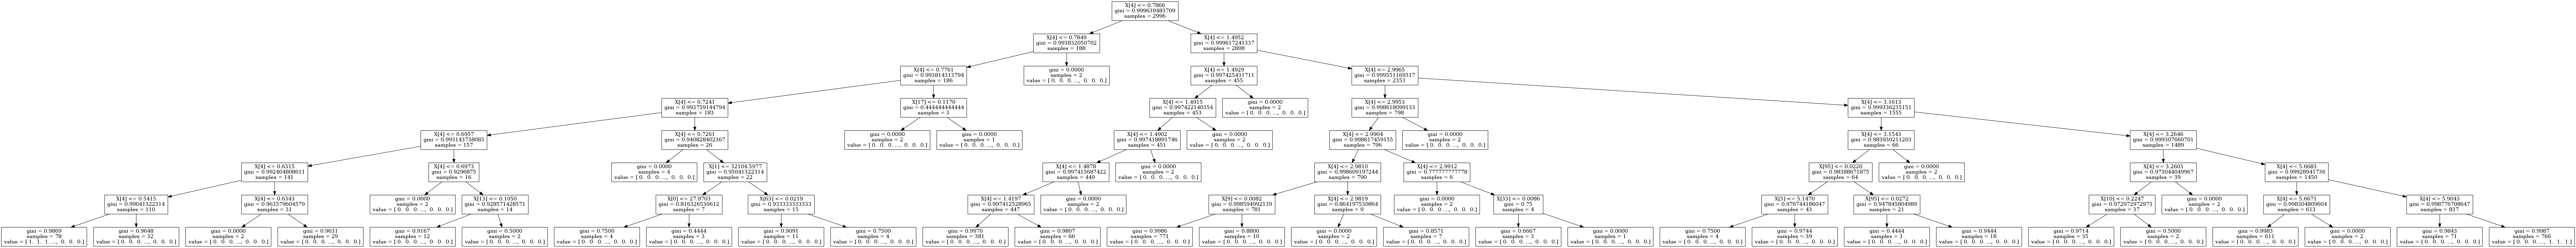

In [313]:
from IPython import display
from sklearn import datasets, tree, utils
from sklearn.externals.six import StringIO  
import pydot 
tree_clf = tree.DecisionTreeClassifier(max_depth=7).fit(X, y)

# Generate a plot of the decision tree
dot_data = StringIO() 
tree.export_graphviz(tree_clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
display.Image(graph.create_png())

In [304]:
cv = cross_validation.ShuffleSplit(len(y), n_iter=20, test_size=0.2, random_state=42)
def compute_error(clf, X, y):
    return - cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='mean_squared_error').mean()


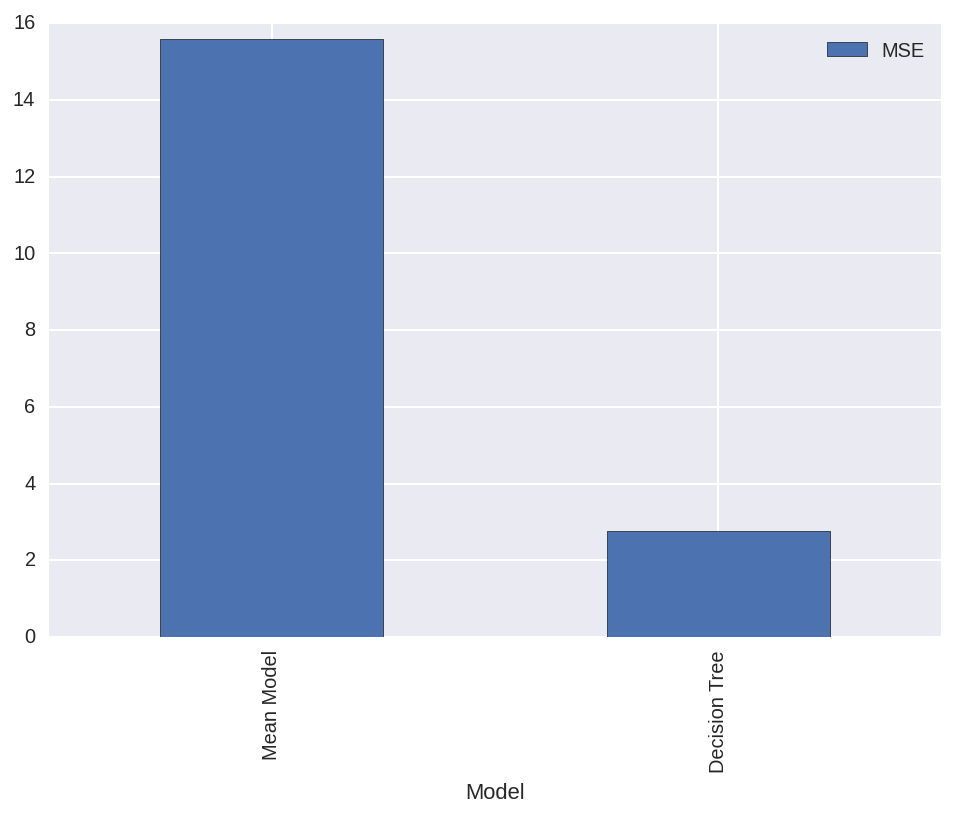

In [310]:
tree_reg = tree.DecisionTreeRegressor()
pd.DataFrame([
    ("Mean Model", y.var()),
    ("Decision Tree", compute_error(tree_reg, X, y))
], columns=["Model", "MSE"]).plot(x="Model", y="MSE", kind="Bar")

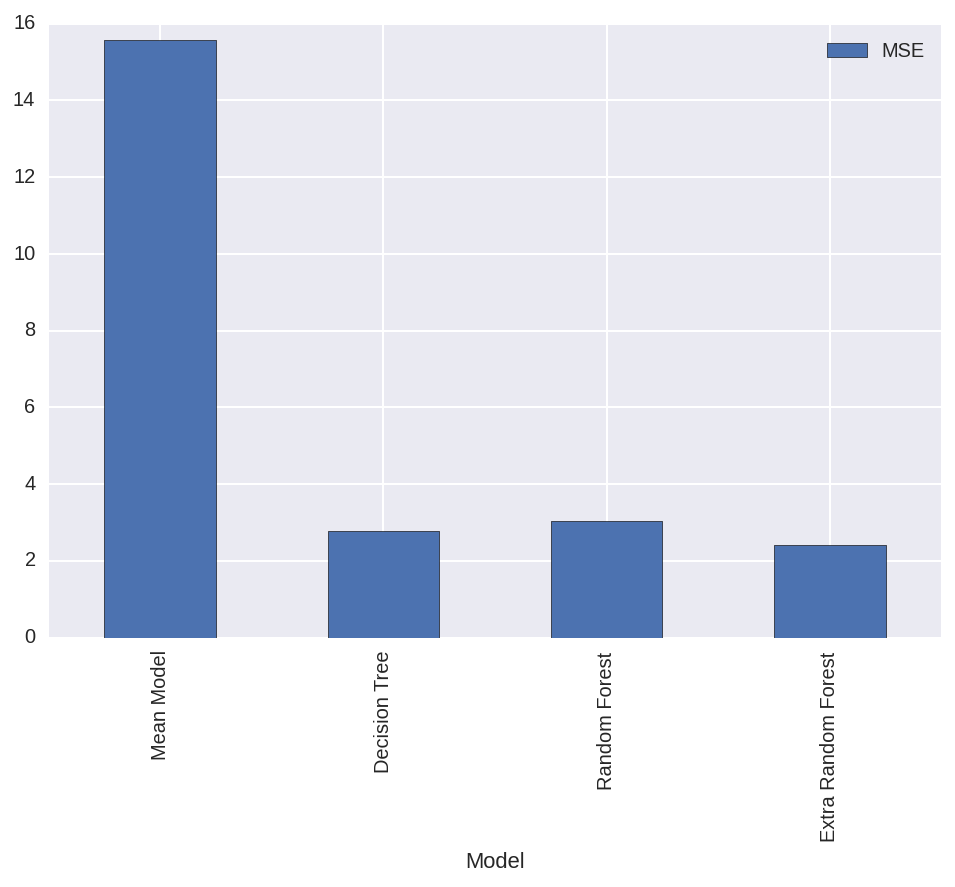

In [314]:
from sklearn import cross_validation, ensemble
import pandas as pd

tree_reg = tree.DecisionTreeRegressor()
extra_reg = ensemble.ExtraTreesRegressor()
forest_reg = ensemble.RandomForestRegressor()

model_performance = pd.DataFrame([
    ("Mean Model", y.var()),
    ("Decision Tree", compute_error(tree_reg, X, y)),
    ("Random Forest", compute_error(forest_reg, X, y)),
    ("Extra Random Forest", compute_error(extra_reg, X, y)),
], columns=["Model", "MSE"])
model_performance.plot(x="Model", y="MSE", kind="Bar")

In [ ]:
# GradientBoostingRegressor
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.02, 'loss': 'ls'}

gradient_reg = ensemble.GradientBoostingRegressor(**params)

gradient_performance = pd.DataFrame([
    ("Gradient Boosted Regressor", compute_error(gradient_reg, X, y))
], columns=["Model", "MSE"])

In [ ]:
model_performance.append(gradient_performance).plot(x="Model", y="MSE", kind="Bar")

In [289]:
from sklearn import svm

In [290]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [323]:
features_num.head()

county_pop_density  AVG_HH_INC_ACS_09_1  AVG_House_Value_ACS_09_13  \
0           92.368073         58441.656166              102790.931593   
1          117.697602         46803.470683              105442.799671   
2           30.875547         34276.234097               79148.108567   
3           36.547855         38778.554648               68405.985010   
4           89.369160         48686.914630               96486.186729   

   housing_density  medianDownload  medianUpload  ind_prop_county_emp  \
0        37.379907         4.97324       1.03272             0.598786   
1        65.825212         2.76063       0.64941             0.430920   
2        13.323916         7.14257       0.48700             0.373183   
3        14.357971         2.69141       0.52800             0.481675   
4        36.860920         2.15430       0.41895             0.558940   

   ind_prop_county_emp  ind_prop_county_emp  ind_prop_county_emp  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

                  ...                   \
0                 ...                    
1                 ...                    
2                 ...                    
3                 ...                    
4                 ...                    

   ind_prop_county_pay Health Care and Social Assistance  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   ind_prop_county_pay Information  ind_prop_county_pay Manufacturing  \
0                                0                           0.000000   
1                                0                           0.011479   
2                                0                           0.000000   
3                                0                           0.000000   
4                                0                           0.000000   

   ind_prop_county_pay Other Services (except Public Administration)  \
0                                                  0                   
1                                                  0                   
2                                                  0                   
3                                                  0                   
4                                                  0                   

   ind_prop_county_pay Professional, Scientific, and Technical Services  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  0                      
4                                                  0                      

   ind_prop_county_pay Real Estate and Rental and Leasing  \
0                                           0.033538        
1                                           0.104448        
2                                           0.004331        
3                                           0.000000        
4                                           0.000410        

   ind_prop_county_pay Retail Trade  \
0                          0.214778   
1                          0.403131   
2                          0.288699   
3                          0.682887   
4                          0.191630   

   ind_prop_county_pay Transportation and Warehousing  \
0                                           0.009069    
1                                           0.021025    
2     

In [324]:
clf.fit(features_num.drop('geoID', axis=1))

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [325]:
features_num['y_pred_train'] = clf.predict(features_num.drop('geoID', axis=1))

In [295]:
y_pred_train.shape

(2996,)

In [297]:
y_pred_train[y_pred_train == -1].size

1804

In [326]:
features_num

geoID  county_pop_density  AVG_HH_INC_ACS_09_1  \
0     01001           92.368073         58441.656166   
1     01003          117.697602         46803.470683   
2     01005           30.875547         34276.234097   
3     01007           36.547855         38778.554648   
4     01009           89.369160         48686.914630   
5     01011           17.254197         41045.143241   
6     01013           26.549026         34072.016917   
7     01015          194.290807         44287.934276   
8     01017           57.239080         36475.939272   
9     01019           47.018241         35888.176761   
10    01021           63.135956         45855.363376   
11    01023           14.983049         36289.329100   
12    01025           20.648932         35286.419263   
13    01027           22.688551         36932.557795   
14    01029           26.682735         40872.385939   
15    01031           74.330126         49506.862047   
16    01033           91.890560         43956.645496   
17    01037           17.203184         30916.147528   
18    01039           36.728435         39697.724730   
19    01041           22.920636         42886.906539   
20    01043          109.545998         43742.194310   
21    01045           89.284823         47437.875116   
22    01047           44.029129         34228.274016   
23    01049           91.463956         38911.472763   
24    01051          129.178557         57124.144050   
25    01053           40.386929         35662.487829   
26    01055          194.883240         42735.886459   
27    01057           27.259982         36774.180865   
28    01059           49.960635         43105.089350   
29    01061           46.640982         41739.386027   
...     ...                 ...                  ...   
2966  55129           19.874171         30774.150608   
2967  55131          306.909682         75982.754474   
2968  55133          711.829248         90277.397941   
2969  55135           69.946811         52204.133307   
2970  55137           39.100605         36851.886030   
2971  55139          386.342451         60824.666649   
2972  55141           93.894091         56028.976756   
2973  56001            8.597653         48932.896620   
2974  56003            3.742633         52269.415488   
2975  56005            9.765530         81010.981357   
2976  56007            2.001753         45951.127732   
2977  56009            3.275530         66463.747073   
2978  56011            2.490884         54226.832680   
2979  56013            4.411784         53191.196745   
2980  56015            6.047479         49940.624475   
2981  56017            2.407575         48698.837209   
2982  56019            2.069014         52499.447514   
2983  56021           34.652341         63233.716919   
2984  56023            4.440489         49464.395040   
2985  56025           14.482756         65740.287519   
2986  56027            0.950101         48152.592036   
2987  56029            4.113609         56503.992967   
2988  56031            4.174727         45722.445490   
2989  56033           11.638696         56720.668044   
2990  56035            2.082866         56139.108567   
2991  56037            4.261867         70615.123769   
2992  56039            5.399987         62846.852984   
2993  56041           10.109241         58642.086537   
2994  56043            3.782808         59419.240838   
2995  56045            2.982792         55514.883324   

      AVG_House_Value_ACS_09_13  housing_density  medianDownload  \
0                 102790.931593        37.379907         4.97324   
1                 105442.799671        65.825212         2.76063   
2                  79148.108567        13.323916         7.14257   
3                  68405.985010        14.357971         2.69141   
4                  96486.186729        36.860920         2.15430   
5                  84266.114593         7.173995        13.83872   
6                  63176.165542        12.784056         

In [329]:
features_num.to_csv('features_with_anom_flag.csv', sep=",", index=False)